# 0005.0000 Modeling Strategy

In [1]:
import pathlib
import sys
import inspect
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / '2007-2008__2009-2010.csv'
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / '2007-2008__2009-2010.csv'
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / '2007-2008__2009-2010.csv'
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'

## Modeling Strategy

1. Load Data and Prepare DataFrame for Modeling

2. Review Time Series Data Splitter for a League Season 

3. Run Poisson Regression to Create Poisson Probabilities Feature

4. Transform the Data from Time-Series to Supervised

5. Review the Transformed Data

6. Model the Transformed Data

7. Score the Model with various parameters

8. Calculate the betting return

## 1. Load Data & Prepare DataFrame for Modeling

In [2]:
df_orig = pd.read_csv(SAMP_STACKED_FP,
                      parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)

### Prepare DataFrame for Modeling

+ Ensure feature columns are floats
+ One hot encode the results column
+ Add meta data - the sequentially numbered game day within each season - required for time series cross validation

In [3]:
def insert_game_day(df_orig):
    """
    Accepts a Dataframe of league matches - may be multiple seasons
    Must have a season column identifying the season, and a date column
    Returns a dataFrame where each game day within a season is consecutively integer numbered
    
    """
    season_dfs = []
    for season in df_orig['season'].unique():
        # Make a bunch of brand spanking new dfs to concat together
        season_df = df_orig[df_orig['season'] == season].copy()
        # Number each game day in the season starting at 0
        season_df['game_day'] = season_df.groupby(by='date').ngroup(ascending=True)
        season_dfs.append(season_df)
    df = pd.concat(season_dfs, axis=0).sort_values(by=['season', 'date'])
    return df

def insert_seasonPercentile(df_orig):
    season_dfs = []
    for season in df_orig['season'].unique():
        # Make a bunch of brand spanking new dfs to concat together
        season_df = df_orig[df_orig['season'] == season].copy()
        # Number each game day in the season starting at 0
        season_df['seasonPercentile'] = season_df['game_day'].rank(method='max', pct=True)
        season_dfs.append(season_df)
    df = pd.concat(season_dfs, axis=0).sort_values(by=['season', 'date'])
    return df

def insert_implied_probabilities(df_orig, odds_cols):
    """
    Accepts a DataFrame and 3 specified ordered columns from that dataframe
    The columns are odds and must be in the order 
    home win, draw, away win
    """
    df = df_orig.copy(deep=True)
    # tot includes the bookie's overround
    tot = 1/df[odds_cols[0]] + 1/df[odds_cols[1]] + 1/df[odds_cols[2]]
    hwin = 1/df[odds_cols[0]]/tot; draw = 1/df[odds_cols[1]]/tot; awin = 1/df[odds_cols[2]]/tot
    df['implied_hwin'] = hwin
    df['implied_draw'] = draw
    df['implied_awin'] = awin
    return df
    

In [4]:
# Specify columns to keep
cols = extend_cols(['hwinOddsBet365', 'drawOddsBet365', 'awinOddsBet365',
                   'hwinOddsLb', 'drawOddsLb', 'awinOddsLb'])
df_orig = df_orig[cols]

# Ensure float datatypes for modeling
int_cols = ['h_shots', 'a_shots', 'h_shotsOnTarget', 'a_shotsOnTarget']
df_orig[int_cols] = df_orig[int_cols].astype(float)

# Dummy Variables for categorical column result
res = df_orig['result']
df_orig = pd.get_dummies(df_orig, columns=['result'], prefix='', prefix_sep='')
# Keep the results column as a convenience column
df_orig['result'] = res

# Add the game day and season percentile meta data
df_orig = insert_game_day(df_orig)

# Add the game day and season percentile meta data
df_orig = insert_seasonPercentile(df_orig)

# Add the odds implied probabilities
df_orig = insert_implied_probabilities(df_orig, ['hwinOddsLb', 'drawOddsLb', 'awinOddsLb'])

df_orig.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin
0,germany,bundesliga,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,16.0,10.0,7.0,4.0,2.37,3.25,2.87,2.10,3.20,3.0,0,1,0,draw,0,0.003268,0.424403,0.278515,0.297082
1,germany,bundesliga,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,27.0,6.0,13.0,0.0,1.16,6.00,19.00,1.20,5.00,11.0,0,0,1,hwin,1,0.022876,0.741240,0.177898,0.080863
2,germany,bundesliga,2007-2008,2007-08-11,bochum,sv-werder-bremen,2.0,2.0,17.0,20.0,4.0,9.0,3.50,3.30,2.05,3.20,3.20,2.0,0,1,0,draw,1,0.022876,0.277778,0.277778,0.444444
3,germany,bundesliga,2007-2008,2007-08-11,eintracht-frankfurt,hertha-berlin,1.0,0.0,19.0,10.0,5.0,3.0,2.37,3.20,2.90,2.37,3.20,2.6,0,0,1,hwin,1,0.022876,0.377051,0.279253,0.343696
4,germany,bundesliga,2007-2008,2007-08-11,hannover,hamburger-sv,0.0,1.0,10.0,14.0,2.0,8.0,2.50,3.20,2.75,2.50,3.25,2.4,1,0,0,awin,1,0.022876,0.355758,0.273660,0.370582


In [5]:
df_orig.tail()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin
913,germany,bundesliga,2009-2010,2010-05-08,mainz,schalke,0.0,0.0,12.0,10.0,4.0,3.0,2.88,3.40,2.38,2.75,3.25,2.20,0,1,0,draw,91,1.0,0.322981,0.273292,0.403727
914,germany,bundesliga,2009-2010,2010-05-08,nurnberg,fc-koln,1.0,0.0,13.0,5.0,3.0,2.0,1.53,4.33,5.50,1.50,3.60,5.50,0,0,1,hwin,91,1.0,0.591928,0.246637,0.161435
915,germany,bundesliga,2009-2010,2010-05-08,sc-freiburg,dortmund,3.0,1.0,14.0,11.0,3.0,5.0,3.75,3.60,1.91,3.50,3.40,1.83,0,0,1,hwin,91,1.0,0.253680,0.261141,0.485180
916,germany,bundesliga,2009-2010,2010-05-08,sv-werder-bremen,hamburger-sv,1.0,1.0,22.0,15.0,8.0,4.0,1.62,4.00,5.25,1.53,3.75,5.00,0,1,0,draw,91,1.0,0.583431,0.238040,0.178530
917,germany,bundesliga,2009-2010,2010-05-08,wolfsburg,eintracht-frankfurt,3.0,1.0,16.0,19.0,7.0,3.0,1.73,4.00,4.20,1.67,3.60,4.00,0,0,1,hwin,91,1.0,0.531522,0.246567,0.221911


In [6]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 27 columns):
nation              918 non-null object
league              918 non-null object
season              918 non-null object
date                918 non-null datetime64[ns]
h                   918 non-null object
a                   918 non-null object
h_ftGoals           918 non-null float64
a_ftGoals           918 non-null float64
h_shots             918 non-null float64
a_shots             918 non-null float64
h_shotsOnTarget     918 non-null float64
a_shotsOnTarget     918 non-null float64
hwinOddsBet365      918 non-null float64
drawOddsBet365      918 non-null float64
awinOddsBet365      918 non-null float64
hwinOddsLb          918 non-null float64
drawOddsLb          918 non-null float64
awinOddsLb          918 non-null float64
awin                918 non-null uint8
draw                918 non-null uint8
hwin                918 non-null uint8
result              918 non-null objec

In [7]:
df = df_orig.copy(deep=True)

## 2. Review Time Series Data Splitter for a League Season

In [8]:
class LeagueSeasonTimeSeriesFold():
    """
    Accepts a league season date sorted DataFrame containing a game_day column
    
    """
    
    def get_game_day_change_indices(self, X_df):
        return X_df['game_day'].diff()[X_df['game_day'].diff() != 0].index.values
    
    def split(self, X_df, y=None, groups=None):
        """
        Accepts a dataframe for a season with a 'game_day' column
        Splits into train, test for each game day in the season
        
        """
        game_day_indices = self.get_game_day_change_indices(X_df)        
        for gd_index in game_day_indices[1:]:
            n_game_day = X_df.loc[gd_index]['game_day']
            train_indices = X_df[X_df['game_day'] < n_game_day].index
            test_indices = X_df[X_df['game_day'] == n_game_day].index
            yield train_indices, test_indices


X_2009 = df[df['season'] == '2009-2010']
lstsf = LeagueSeasonTimeSeriesFold()


n =0
for train_index, test_index in lstsf.split(X_2009):

    print('train:')
    print(X_2009[['h', 'a', 'date', 'game_day']].loc[train_index])
    print('test:')
    print(X_2009[['h', 'a', 'date', 'game_day']].loc[test_index])
    print('\n')
    n  += 1
    if n >= 4:
        break

train:
             h          a       date  game_day
612  wolfsburg  stuttgart 2009-08-07         0
test:
                    h                    a       date  game_day
613          dortmund              fc-koln 2009-08-08         1
614     hertha-berlin             hannover 2009-08-08         1
615        hoffenheim        bayern-munich 2009-08-08         1
616             mainz           leverkusen 2009-08-08         1
617          nurnberg              schalke 2009-08-08         1
618  sv-werder-bremen  eintracht-frankfurt 2009-08-08         1


train:
                    h                    a       date  game_day
612         wolfsburg            stuttgart 2009-08-07         0
613          dortmund              fc-koln 2009-08-08         1
614     hertha-berlin             hannover 2009-08-08         1
615        hoffenheim        bayern-munich 2009-08-08         1
616             mainz           leverkusen 2009-08-08         1
617          nurnberg              schalke 2009-08-0

## 3. Run Poisson Regression to Create Poisson Probabilities Feature

#### Poisson Regression Model

In [9]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import numpy as np
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.sm_exceptions as sm_exceptions


class PoissonRegression(BaseEstimator, ClassifierMixin):
    """
    Adapted from:
    https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/
    fit accepts a DataFrame representing an early part of a league season
    Reshapes the data, and fits a Regression Model based on this data
    predict / predict_proba accepts a dataFrame representing a later, consecutive
    part of a league season. Reshapes the data and makes, and returns
    home win, draw, and away win probabilities
    
    DataFrame must have the following data columns
    h - home team, a - away team
    h_ftGoals - home team full time goals
    a_ftGoals - away team full time goals
    """
    def __init__(self, family=sm.families.Poisson(),
                 formula='goals ~ home + team + opponent',
                 max_goals=10):
        self.family = family
        self.formula = formula
        self.max_goals = max_goals
        self.epsilon = 0.1
        self.model = None

    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : Not used
        Returns
        -------
        self : object
            Returns self.
        """
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        
        # Reshape the data
        self.reshaped_X_ = pd.concat([self.X_[['h','a','h_ftGoals']].assign(home=1).rename(
                             columns={'h':'team', 'a':'opponent','h_ftGoals':'goals'}),
                             self.X_[['a','h','a_ftGoals']].assign(home=0).rename(
                             columns={'a':'team', 'h':'opponent','a_ftGoals':'goals'})])
        
        # fit the model - have to handle perfect separation or not enough data
        # If exception - catch and the the model to None
        # If we see  None model in predict, we can return 0 probabilities
        # to show that the model did not do the prediction 
        try:
            self.model= smf.glm(formula=self.formula,
                                data=self.reshaped_X_, 
                                family=self.family).fit()
        except sm_exceptions.PerfectSeparationError:
            # print('sm_exceptions.PerfectSeparationError')
            self.model=None
        except ValueError:
            # print('ValueError')
            self.model=None        
        
        # Return the classifier
        return self.model
    

    def calc_probas(self, row):
        team_pred = [[poisson.pmf(i, team_avg) for i in range(0, self.max_goals+1)] \
                     for team_avg in [row['h_lambda'], row['a_lambda']]]
        prob_table = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
        phwin = np.sum(np.tril(prob_table, -1))
        pdraw = np.sum(np.diag(prob_table))
        pawin = np.sum(np.triu(prob_table, 1))
        # Return in same sequence as classes_
        return pawin, pdraw, phwin
        

    def predict(self, X):
        """ A reference implementation of a prediction for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        # X = check_array(X)
        
        if self.model is not None:
        # Reshape the data and make the poisson predictions
            h_preds = self.model.predict(pd.DataFrame(data={'team': X['h'].values,
                                                   'opponent': X['a'].values,
                                                   'home':1}))
            a_preds = self.model.predict(pd.DataFrame(data={'team': X['a'].values,
                                                      'opponent': X['h'].values,
                                                      'home':0}))
            temp_df = pd.DataFrame({'h_lambda': h_preds, 'a_lambda': a_preds})
            self.probas = temp_df.apply(self.calc_probas, axis=1, result_type='expand')
            self.probas.columns = ['poiss_p(awin)', 'poiss_p(draw)', 'poiss_p(hwin)']
        else:
#             self.probas = pd.DataFrame({'poiss_p(awin)': [0]*len(X),
#                                    'poiss_p(draw)': [0]*len(X),
#                                    'poiss_p(hwin)': [0]*len(X)})
            self.probas = pd.DataFrame({'poiss_p(awin)': [np.NaN]*len(X),
                                   'poiss_p(draw)': [np.NaN]*len(X),
                                   'poiss_p(hwin)': [np.NaN]*len(X)})
            
        # When there is not enough data to predict, the model can create some non-sensical probabilities
        # Clean these up by setting all 3 probabilities to 0
        crit1 = self.probas.sum(axis=1) < 1.0 - self.epsilon
        crit2 = self.probas.sum(axis=1) > 1.0 + self.epsilon
        self.probas[crit1 | crit2] = np.NaN
        
        # Set the index of the returned probabilities to match the input data
        self.probas.index = X.index
        
        return self.probas.idxmax(axis=1)
        
        
    def predict_proba(self, X):
        self.predict(X)
        return self.probas

#### Applying the Model to Each Season to Create the Features

In [10]:
df = df_orig.copy(deep=True)
 
season_dfs = []
# Split the full dataframe into season dataframes
for season in sorted(df['season'].unique()):
    season_df = df[df['season'] == season].copy(deep=True)
    game_day_splitter = LeagueSeasonTimeSeriesFold()
    for train_indices, predict_indices in game_day_splitter.split(season_df):
        # Instantiate, fit and predict the poisson regression for each train, predict split
        clf = PoissonRegression()
        clf.fit(season_df.loc[train_indices], season_df.loc[train_indices, 'result'])
        preds = clf.predict_proba(season_df.loc[predict_indices])
        # Add the returned features back into the season dataframe
        for i, col in enumerate(preds.columns):
            season_df.loc[preds.index, preds.columns[i]] = preds[preds.columns[i]].values
    season_dfs.append(season_df)
# Put the full DataFrame with the additional features back together for all seasons
df2 = pd.concat(season_dfs, axis=0)

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/regression/_tools.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/links.

#### Reviewing the New Features

In [11]:
df2.head(45)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,poiss_p(awin),poiss_p(draw),poiss_p(hwin)
0,germany,bundesliga,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,16.0,10.0,7.0,4.0,2.37,3.25,2.87,2.10,3.20,3.00,0,1,0,draw,0,0.003268,0.424403,0.278515,0.297082,NaN,NaN,NaN
1,germany,bundesliga,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,27.0,6.0,13.0,0.0,1.16,6.00,19.00,1.20,5.00,11.00,0,0,1,hwin,1,0.022876,0.741240,0.177898,0.080863,NaN,NaN,NaN
2,germany,bundesliga,2007-2008,2007-08-11,bochum,sv-werder-bremen,2.0,2.0,17.0,20.0,4.0,9.0,3.50,3.30,2.05,3.20,3.20,2.00,0,1,0,draw,1,0.022876,0.277778,0.277778,0.444444,NaN,NaN,NaN
3,germany,bundesliga,2007-2008,2007-08-11,eintracht-frankfurt,hertha-berlin,1.0,0.0,19.0,10.0,5.0,3.0,2.37,3.20,2.90,2.37,3.20,2.60,0,0,1,hwin,1,0.022876,0.377051,0.279253,0.343696,NaN,NaN,NaN
4,germany,bundesliga,2007-2008,2007-08-11,hannover,hamburger-sv,0.0,1.0,10.0,14.0,2.0,8.0,2.50,3.20,2.75,2.50,3.25,2.40,1,0,0,awin,1,0.022876,0.355758,0.273660,0.370582,NaN,NaN,NaN
5,germany,bundesliga,2007-2008,2007-08-11,leverkusen,energie-cottbus,0.0,0.0,21.0,10.0,7.0,5.0,1.53,3.80,6.00,1.50,3.40,6.00,0,1,0,draw,1,0.022876,0.591304,0.260870,0.147826,NaN,NaN,NaN
6,germany,bundesliga,2007-2008,2007-08-11,wolfsburg,bielefeld,1.0,3.0,13.0,13.0,4.0,8.0,2.00,3.30,3.60,1.90,3.20,3.50,1,0,0,awin,1,0.022876,0.468032,0.277894,0.254074,NaN,NaN,NaN
7,germany,bundesliga,2007-2008,2007-08-12,dortmund,duisburg,1.0,3.0,12.0,7.0,4.0,4.0,1.53,3.80,6.00,1.53,3.40,5.50,1,0,0,awin,2,0.029412,0.578643,0.260389,0.160968,NaN,NaN,NaN
8,germany,bundesliga,2007-2008,2007-08-12,nurnberg,karlsruher,0.0,2.0,19.0,11.0,7.0,7.0,1.80,3.30,4.50,1.66,3.40,4.33,1,0,0,awin,2,0.029412,0.534300,0.260864,0.204836,NaN,NaN,NaN
9,germany,bundesliga,2007-2008,2007-08-17,karlsruher,hannover,1.0,2.0,6.0,10.0,1.0,3.0,2.37,3.25,2.87,2.20,3.25,2.75,1,0,0,awin,3,0.032680,0.403727,0.273292,0.322981,NaN,NaN,NaN


In [12]:
df2.tail()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,poiss_p(awin),poiss_p(draw),poiss_p(hwin)
913,germany,bundesliga,2009-2010,2010-05-08,mainz,schalke,0.0,0.0,12.0,10.0,4.0,3.0,2.88,3.40,2.38,2.75,3.25,2.20,0,1,0,draw,91,1.0,0.322981,0.273292,0.403727,0.492853,0.288792,0.218355
914,germany,bundesliga,2009-2010,2010-05-08,nurnberg,fc-koln,1.0,0.0,13.0,5.0,3.0,2.0,1.53,4.33,5.50,1.50,3.60,5.50,0,0,1,hwin,91,1.0,0.591928,0.246637,0.161435,0.413702,0.306825,0.279473
915,germany,bundesliga,2009-2010,2010-05-08,sc-freiburg,dortmund,3.0,1.0,14.0,11.0,3.0,5.0,3.75,3.60,1.91,3.50,3.40,1.83,0,0,1,hwin,91,1.0,0.253680,0.261141,0.485180,0.597870,0.226394,0.175732
916,germany,bundesliga,2009-2010,2010-05-08,sv-werder-bremen,hamburger-sv,1.0,1.0,22.0,15.0,8.0,4.0,1.62,4.00,5.25,1.53,3.75,5.00,0,1,0,draw,91,1.0,0.583431,0.238040,0.178530,0.257035,0.218959,0.523998
917,germany,bundesliga,2009-2010,2010-05-08,wolfsburg,eintracht-frankfurt,3.0,1.0,16.0,19.0,7.0,3.0,1.73,4.00,4.20,1.67,3.60,4.00,0,0,1,hwin,91,1.0,0.531522,0.246567,0.221911,0.285043,0.203489,0.511446


We want our poisson regression probabailities to be tretaed as features when we transform the data.

The code treats a column as a feature if it is prefixed by `h_` or `a_`

Therefore we need to add this prefix

In the production version of the PoissonRegression Classifier these prefixed columns will be returned

We gave 3 probabilities associated with 2 teams. One of the probabilities applies to both team - the draw probability - Explain here !!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

therefore, we will end up with each team having 2 probabilities as features - win and draw - enumerated below

Home Team
+ p(win) h_poissWin
+ p(draw) h_poissDraw
+ p(lose) h_poissLose

Away Team
+ p(win) a_poissWin
+ p(draw) a_poissDraw
+ p(lose) a_poissLose


In [13]:
# We have 3 probabilities we distribute amongst 2 teams
df2.rename(columns={'poiss_p(hwin)': 'h_poissWin', 'poiss_p(draw)': 'h_poissDraw', 'poiss_p(awin)': 'h_poissLose'},
           inplace=True)
df2['a_poissDraw'] = df2['h_poissDraw']
df2['a_poissWin'] = df2['h_poissLose']
df2['a_poissLose'] = df2['h_poissWin']

df2.head(2)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,h_poissLose,h_poissDraw,h_poissWin,a_poissDraw,a_poissWin,a_poissLose
0,germany,bundesliga,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,16.0,10.0,7.0,4.0,2.37,3.25,2.87,2.1,3.2,3.0,0,1,0,draw,0,0.003268,0.424403,0.278515,0.297082,NaN,NaN,NaN,NaN,NaN,NaN
1,germany,bundesliga,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,27.0,6.0,13.0,0.0,1.16,6.00,19.00,1.2,5.0,11.0,0,0,1,hwin,1,0.022876,0.741240,0.177898,0.080863,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# save the data into a separate directory under the sample directory

df2.to_csv(SAMP_FEATURED_FP, index=False)

## 4. Transform the Data from Time-Series to Supervised

The source code is built to run on specific directories e.g. FEATURED_DIR, TRANSFORMED_DIR - see below - these are python CONSTANTS

We will override these constants so we can use the same module on our sample data

Below, we can see the main function we will run on the dataframe we created above

The function that does the work is transform_ts_to_supervised

In [15]:
print(inspect.getsource(run_transform_ts_to_supervised))

def run_transform_ts_to_supervised():
    filepaths = get_filepaths(FEATURED_DIR, ext='csv')
    dfs = read_csvs_to_dfs(filepaths)
    features = None
    df_tss = []
    for df in dfs:
        # Need to group by season here before applying transform
        # Then need to restack after transformation applied
        season_dfs = []
        for ind, season_df in df.groupby(by='season'):
            season_df_t = transform_ts_to_supervised(season_df, features)
            season_dfs.append(season_df_t)
        league_df = pd.concat(season_dfs, sort=True, axis=0)
        df_tss.append(league_df)
    transformed_filepaths = make_equiv_image_dest_fps(FEATURED_DIR,
                                                      TRANSFORMED_DIR,
                                                      filepaths)
    n_saved = write_dfs_to_filepaths(df_tss, transformed_filepaths)
    print(n_saved)



In [16]:
from src.data import transform_long_to_wide
transform_long_to_wide.FEATURED_DIR = SAMP_FEATURED_DIR
transform_long_to_wide.TRANSFORMED_DIR = SAMP_TRANSFORMED_DIR


In [17]:
run_transform_ts_to_supervised()

1


# 5. Review the Transformed Data

In [18]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [19]:
df_trans.head(2)

,a,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_poissDraw-0,a_a_poissDraw-1,a_a_poissDraw-10,a_a_poissDraw-11,a_a_poissDraw-12,a_a_poissDraw-13,a_a_poissDraw-14,a_a_poissDraw-15,a_a_poissDraw-16,a_a_poissDraw-2,a_a_poissDraw-3,a_a_poissDraw-4,a_a_poissDraw-5,a_a_poissDraw-6,a_a_poissDraw-7,a_a_poissDraw-8,a_a_poissDraw-9,a_a_poissLose-0,a_a_poissLose-1,a_a_poissLose-10,a_a_poissLose-11,a_a_poissLose-12,a_a_poissLose-13,a_a_poissLose-14,a_a_poissLose-15,a_a_poissLose-16,a_a_poissLose-2,a_a_poissLose-3,a_a_poissLose-4,a_a_poissLose-5,a_a_poissLose-6,a_a_poissLose-7,a_a_poissLose-8,a_a_poissLose-9,a_a_poissWin-0,a_a_poissWin-1,a_a_poissWin-10,a_a_poissWin-11,a_a_poissWin-12,a_a_poissWin-13,a_a_poissWin-14,a_a_poissWin-15,a_a_poissWin-16,a_a_poissWin-2,a_a_poissWin-3,a_a_poissWin-4,a_a_poissWin-5,a_a_poissWin-6,a_a_poissWin-7,a_a_poissWin-8,a_a_poissWin-9,a_a_shots-0,a_a_shots-1,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shotsOnTarget-0,a_a_shotsOnTarget-1,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_ftGoals,a_h_ftGoals-1,a_h_ftGoals-10,a_h_ftGoals-11,a_h_ftGoals-12,a_h_ftGoals-13,a_h_ftGoals-14,a_h_ftGoals-15,a_h_ftGoals-16,a_h_ftGoals-17,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,a_h_ftGoals-9,a_h_poissDraw-1,a_h_poissDraw-10,a_h_poissDraw-11,a_h_poissDraw-12,a_h_poissDraw-13,a_h_poissDraw-14,a_h_poissDraw-15,a_h_poissDraw-16,a_h_poissDraw-2,a_h_poissDraw-3,a_h_poissDraw-4,a_h_poissDraw-5,a_h_poissDraw-6,a_h_poissDraw-7,a_h_poissDraw-8,a_h_poissDraw-9,a_h_poissLose-1,a_h_poissLose-10,a_h_poissLose-11,a_h_poissLose-12,a_h_poissLose-13,a_h_poissLose-14,a_h_poissLose-15,a_h_poissLose-16,a_h_poissLose-2,a_h_poissLose-3,a_h_poissLose-4,a_h_poissLose-5,a_h_poissLose-6,a_h_poissLose-7,a_h_poissLose-8,a_h_poissLose-9,a_h_poissWin-1,a_h_poissWin-10,a_h_poissWin-11,a_h_poissWin-12,a_h_poissWin-13,a_h_poissWin-14,a_h_poissWin-15,a_h_poissWin-16,a_h_poissWin-2,a_h_poissWin-3,a_h_poissWin-4,a_h_poissWin-5,a_h_poissWin-6,a_h_poissWin-7,a_h_poissWin-8,a_h_poissWin-9,a_h_shots-1,a_h_shots-10,a_h_shots-11,a_h_shots-12,a_h_shots-13,a_h_shots-14,a_h_shots-15,a_h_shots-16,a_h_shots-17,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,a_h_shots-9,a_h_shotsOnTarget-1,a_h_shotsOnTarget-10,a_h_shotsOnTarget-11,a_h_shotsOnTarget-12,a_h_shotsOnTarget-13,a_h_shotsOnTarget-14,a_h_shotsOnTarget-15,a_h_shotsOnTarget-16,a_h_shotsOnTarget-17,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,a_h_shotsOnTarget-9,a_poissDraw,a_poissLose,a_poissWin,a_shots,a_shotsOnTarget,awin,awinOddsBet365,awinOddsLb,date,draw,drawOddsBet365,drawOddsLb,game_day,h,h_a_ftGoals-1,h_a_ftGoals-10,h_a_ftGoals-11,h_a_ftGoals-12,h_a_ftGoals-13,h_a_ftGoals-14,h_a_ftGoals-15,h_a_ftGoals-16,h_a_ftGoals-17,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_a_ftGoals-9,h_a_poissDraw-1,h_a_poissDraw-10,h_a_poissDraw-11,h_a_poissDraw-12,h_a_poissDraw-13,h_a_poissDraw-14,h_a_poissDraw-15,h_a_poissDraw-16,h_a_poissDraw-2,h_a_poissDraw-3,h_a_poissDraw-4,h_a_poissDraw-5,h_a_poissDraw-6,h_a_poissDraw-7,h_a_poissDraw-8,h_a_poissDraw-9,h_a_poissLose-1,h_a_poissLose-10,h_a_poissLose-11,h_a_poissLose-12,h_a_poissLose-13,h_a_poissLose-14,h_a_poissLose-15,h_a_poissLose-16,h_a_

In [20]:
df_trans.tail(2)

,a,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_poissDraw-0,a_a_poissDraw-1,a_a_poissDraw-10,a_a_poissDraw-11,a_a_poissDraw-12,a_a_poissDraw-13,a_a_poissDraw-14,a_a_poissDraw-15,a_a_poissDraw-16,a_a_poissDraw-2,a_a_poissDraw-3,a_a_poissDraw-4,a_a_poissDraw-5,a_a_poissDraw-6,a_a_poissDraw-7,a_a_poissDraw-8,a_a_poissDraw-9,a_a_poissLose-0,a_a_poissLose-1,a_a_poissLose-10,a_a_poissLose-11,a_a_poissLose-12,a_a_poissLose-13,a_a_poissLose-14,a_a_poissLose-15,a_a_poissLose-16,a_a_poissLose-2,a_a_poissLose-3,a_a_poissLose-4,a_a_poissLose-5,a_a_poissLose-6,a_a_poissLose-7,a_a_poissLose-8,a_a_poissLose-9,a_a_poissWin-0,a_a_poissWin-1,a_a_poissWin-10,a_a_poissWin-11,a_a_poissWin-12,a_a_poissWin-13,a_a_poissWin-14,a_a_poissWin-15,a_a_poissWin-16,a_a_poissWin-2,a_a_poissWin-3,a_a_poissWin-4,a_a_poissWin-5,a_a_poissWin-6,a_a_poissWin-7,a_a_poissWin-8,a_a_poissWin-9,a_a_shots-0,a_a_shots-1,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shotsOnTarget-0,a_a_shotsOnTarget-1,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_ftGoals,a_h_ftGoals-1,a_h_ftGoals-10,a_h_ftGoals-11,a_h_ftGoals-12,a_h_ftGoals-13,a_h_ftGoals-14,a_h_ftGoals-15,a_h_ftGoals-16,a_h_ftGoals-17,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,a_h_ftGoals-9,a_h_poissDraw-1,a_h_poissDraw-10,a_h_poissDraw-11,a_h_poissDraw-12,a_h_poissDraw-13,a_h_poissDraw-14,a_h_poissDraw-15,a_h_poissDraw-16,a_h_poissDraw-2,a_h_poissDraw-3,a_h_poissDraw-4,a_h_poissDraw-5,a_h_poissDraw-6,a_h_poissDraw-7,a_h_poissDraw-8,a_h_poissDraw-9,a_h_poissLose-1,a_h_poissLose-10,a_h_poissLose-11,a_h_poissLose-12,a_h_poissLose-13,a_h_poissLose-14,a_h_poissLose-15,a_h_poissLose-16,a_h_poissLose-2,a_h_poissLose-3,a_h_poissLose-4,a_h_poissLose-5,a_h_poissLose-6,a_h_poissLose-7,a_h_poissLose-8,a_h_poissLose-9,a_h_poissWin-1,a_h_poissWin-10,a_h_poissWin-11,a_h_poissWin-12,a_h_poissWin-13,a_h_poissWin-14,a_h_poissWin-15,a_h_poissWin-16,a_h_poissWin-2,a_h_poissWin-3,a_h_poissWin-4,a_h_poissWin-5,a_h_poissWin-6,a_h_poissWin-7,a_h_poissWin-8,a_h_poissWin-9,a_h_shots-1,a_h_shots-10,a_h_shots-11,a_h_shots-12,a_h_shots-13,a_h_shots-14,a_h_shots-15,a_h_shots-16,a_h_shots-17,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,a_h_shots-9,a_h_shotsOnTarget-1,a_h_shotsOnTarget-10,a_h_shotsOnTarget-11,a_h_shotsOnTarget-12,a_h_shotsOnTarget-13,a_h_shotsOnTarget-14,a_h_shotsOnTarget-15,a_h_shotsOnTarget-16,a_h_shotsOnTarget-17,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,a_h_shotsOnTarget-9,a_poissDraw,a_poissLose,a_poissWin,a_shots,a_shotsOnTarget,awin,awinOddsBet365,awinOddsLb,date,draw,drawOddsBet365,drawOddsLb,game_day,h,h_a_ftGoals-1,h_a_ftGoals-10,h_a_ftGoals-11,h_a_ftGoals-12,h_a_ftGoals-13,h_a_ftGoals-14,h_a_ftGoals-15,h_a_ftGoals-16,h_a_ftGoals-17,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_a_ftGoals-9,h_a_poissDraw-1,h_a_poissDraw-10,h_a_poissDraw-11,h_a_poissDraw-12,h_a_poissDraw-13,h_a_poissDraw-14,h_a_poissDraw-15,h_a_poissDraw-16,h_a_poissDraw-2,h_a_poissDraw-3,h_a_poissDraw-4,h_a_poissDraw-5,h_a_poissDraw-6,h_a_poissDraw-7,h_a_poissDraw-8,h_a_poissDraw-9,h_a_poissLose-1,h_a_poissLose-10,h_a_poissLose-11,h_a_poissLose-12,h_a_poissLose-13,h_a_poissLose-14,h_a_poissLose-15,h_a_poissLose-16,h_a_

We have these historical features for each team playing a match

So, consider a mtach being played today

To get the **number of goals** scored by the **home team** in the **last 2 games** they played **at home**:
+ h_h_ftGoals-1
+ h_h_ftGoals-2

To get the **number of goals** scored by the **home team** in the **last 3 games** they played **away**:
+ h_a_ftGoals-1
+ h_a_ftGoals-2
+ h_a_ftGoals-3

To get the **poisson regression probability of winning** for the **away team** in the **last (1) game** they played **away**:
+ a_a_poissWin-1

Feature Nomenclature & Time Series to Supervised

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

https://machinelearningmastery.com/time-series-forecasting-supervised-learning/

DataFrame in time sequence where index 0 is the earliest game, and index max is the latest game

There are 2 teams per game `h` and `a`, where h indicates the team played at home, and a - away.

Each team has generated a feature by the end of the game - `h_feat`, and `a_feat`

There could be multiple features, meaning a double  set for each feature

Each team has a home game record and an away game record

So, there are 4 records to get for each feature
+ home team home record `h_h`
+ home team away record `h_a`
+ away team home record `a_h`
+ away team away record `a_a`

Results presented as 0, -1, -2 ... -n where 0 referes to the current game. This column can be used as a predictor variable for classification, or used as a classification response, or dropped and just the previous game features used for prediction

### Interpretation Note

`h_h_feat_-1` means:
+ (`h`) home team 
+ (`h`) home game records 
+ (`feat`) feature value in 
+ (`-1`) last game


Put the features into order and take a look at the shape of the data

In [21]:
def get_feature_cols(df):
    features = sorted(list(set([col.split('-')[0] for col in df.columns if '-' in col])))
    return features

def get_sorted_feature_cols(df):
    # Grab the feature names
    #features = sorted(list(set([col.split('-')[0] for col in df.columns if '-' in col])))
    features = get_feature_cols(df)
    features_list = []
    for feature in features:
        unsorted_feature_list = [col for col in df.columns if feature == col.rsplit('-',1)[0]]
        unsorted_feature_list.sort(key=lambda x: int(x.rsplit('-',1)[1]))
        features_list.extend(unsorted_feature_list)
    return features_list
    
sorted_feature_cols = get_sorted_feature_cols(df_trans)
other_cols = [col for col in df.columns if col not in sorted_feature_cols]
all_cols = other_cols + sorted_feature_cols
#+ ['hwinOddsBet365', 'drawOddsBet365', 'awinOddsBet365',
#                                      'hwinOddsLb', 'drawOddsLb', 'awinOddsLb']
#all_cols = extend_cols(defined_cols)

In [22]:
df_trans2 = df_trans[all_cols].copy(deep=True)
df_trans2.head(2)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_poissDraw-0,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissDraw-3,a_a_poissDraw-4,a_a_poissDraw-5,a_a_poissDraw-6,a_a_poissDraw-7,a_a_poissDraw-8,a_a_poissDraw-9,a_a_poissDraw-10,a_a_poissDraw-11,a_a_poissDraw-12,a_a_poissDraw-13,a_a_poissDraw-14,a_a_poissDraw-15,a_a_poissDraw-16,a_a_poissLose-0,a_a_poissLose-1,a_a_poissLose-2,a_a_poissLose-3,a_a_poissLose-4,a_a_poissLose-5,a_a_poissLose-6,a_a_poissLose-7,a_a_poissLose-8,a_a_poissLose-9,a_a_poissLose-10,a_a_poissLose-11,a_a_poissLose-12,a_a_poissLose-13,a_a_poissLose-14,a_a_poissLose-15,a_a_poissLose-16,a_a_poissWin-0,a_a_poissWin-1,a_a_poissWin-2,a_a_poissWin-3,a_a_poissWin-4,a_a_poissWin-5,a_a_poissWin-6,a_a_poissWin-7,a_a_poissWin-8,a_a_poissWin-9,a_a_poissWin-10,a_a_poissWin-11,a_a_poissWin-12,a_a_poissWin-13,a_a_poissWin-14,a_a_poissWin-15,a_a_poissWin-16,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shotsOnTarget-0,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,a_h_ftGoals-9,a_h_ftGoals-10,a_h_ftGoals-11,a_h_ftGoals-12,a_h_ftGoals-13,a_h_ftGoals-14,a_h_ftGoals-15,a_h_ftGoals-16,a_h_ftGoals-17,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissDraw-3,a_h_poissDraw-4,a_h_poissDraw-5,a_h_poissDraw-6,a_h_poissDraw-7,a_h_poissDraw-8,a_h_poissDraw-9,a_h_poissDraw-10,a_h_poissDraw-11,a_h_poissDraw-12,a_h_poissDraw-13,a_h_poissDraw-14,a_h_poissDraw-15,a_h_poissDraw-16,a_h_poissLose-1,a_h_poissLose-2,a_h_poissLose-3,a_h_poissLose-4,a_h_poissLose-5,a_h_poissLose-6,a_h_poissLose-7,a_h_poissLose-8,a_h_poissLose-9,a_h_poissLose-10,a_h_poissLose-11,a_h_poissLose-12,a_h_poissLose-13,a_h_poissLose-14,a_h_poissLose-15,a_h_poissLose-16,a_h_poissWin-1,a_h_poissWin-2,a_h_poissWin-3,a_h_poissWin-4,a_h_poissWin-5,a_h_poissWin-6,a_h_poissWin-7,a_h_poissWin-8,a_h_poissWin-9,a_h_poissWin-10,a_h_poissWin-11,a_h_poissWin-12,a_h_poissWin-13,a_h_poissWin-14,a_h_poissWin-15,a_h_poissWin-16,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,a_h_shots-9,a_h_shots-10,a_h_shots-11,a_h_shots-12,a_h_shots-13,a_h_shots-14,a_h_shots-15,a_h_shots-16,a_h_shots-17,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,a_h_shotsOnTarget-9,a_h_shotsOnTarget-10,a_h_shotsOnTarget-11,a_h_shotsOnTarget-12,a_h_shotsOnTarget-13,a_h_shotsOnTarget-14,a_h_shotsOnTarget-15,a_h_shotsOnTarget-16,a_h_shotsOnTarget-17,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_a_ftGoals-9,h_a_ftGoals-10,h_a_ftGoals-11,h_a_ftGoals-12,h_a_ftGoals-13,h_a_ftGoals-14,h_a_ftGoals-15,h_a_ftGoals-16,h_a_ftGoals-17,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissDraw-3,h_a_poissDraw-4,h_a_poissDraw-5,h_a_poissDraw-6,h_a_poissDraw-7,h_a_poissDraw-8,h_a_poissDraw-9,h_a_poissDraw-10,h_a_poissDraw-11,h_a_poissDraw-12,h_a_poissDraw-13,h_a_poissDraw-14,h_a_poissDraw-15,h_a_poissDraw-16,h_a_poissLose-1,h_a_poiss

As the season progresses, more historical data becomes available, which is seen in the missing data plot below

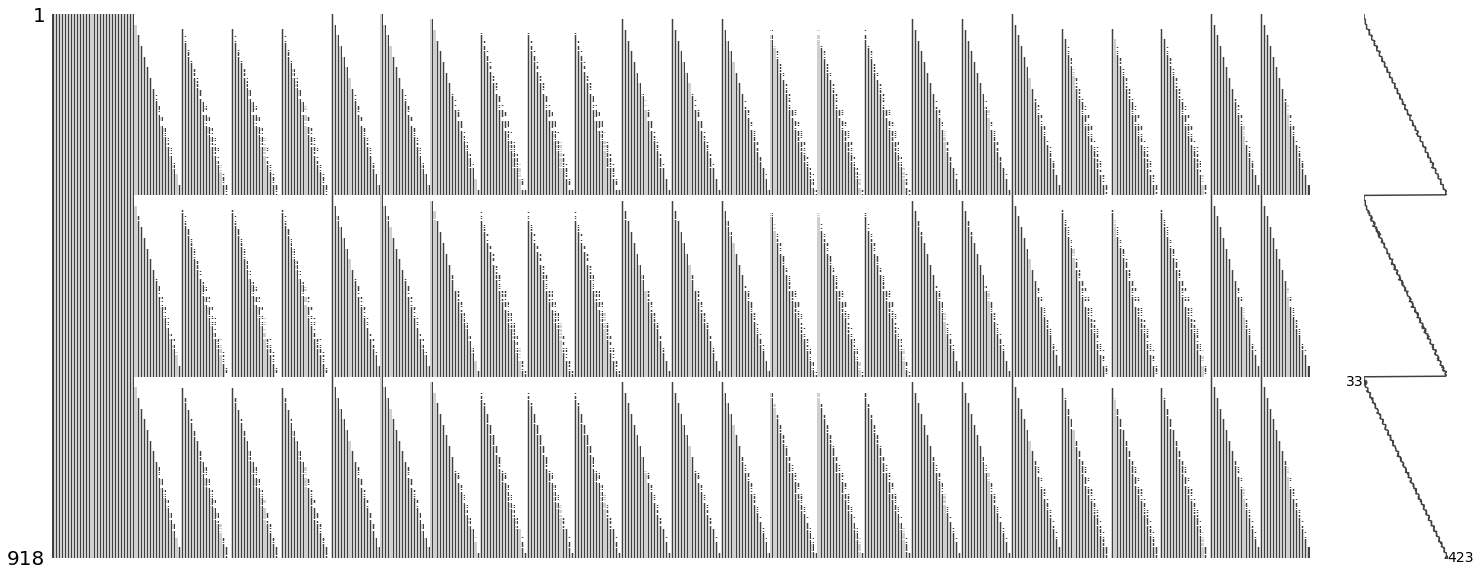

In [23]:
msno.matrix(df_trans2)
plt.show();

Reviewing a single feature

As the season progresses, more historical data builds up, and the row fills in

Note thgat the suffix `_0` applies to the current game, so we need to drop these `0` columns prior to modeling

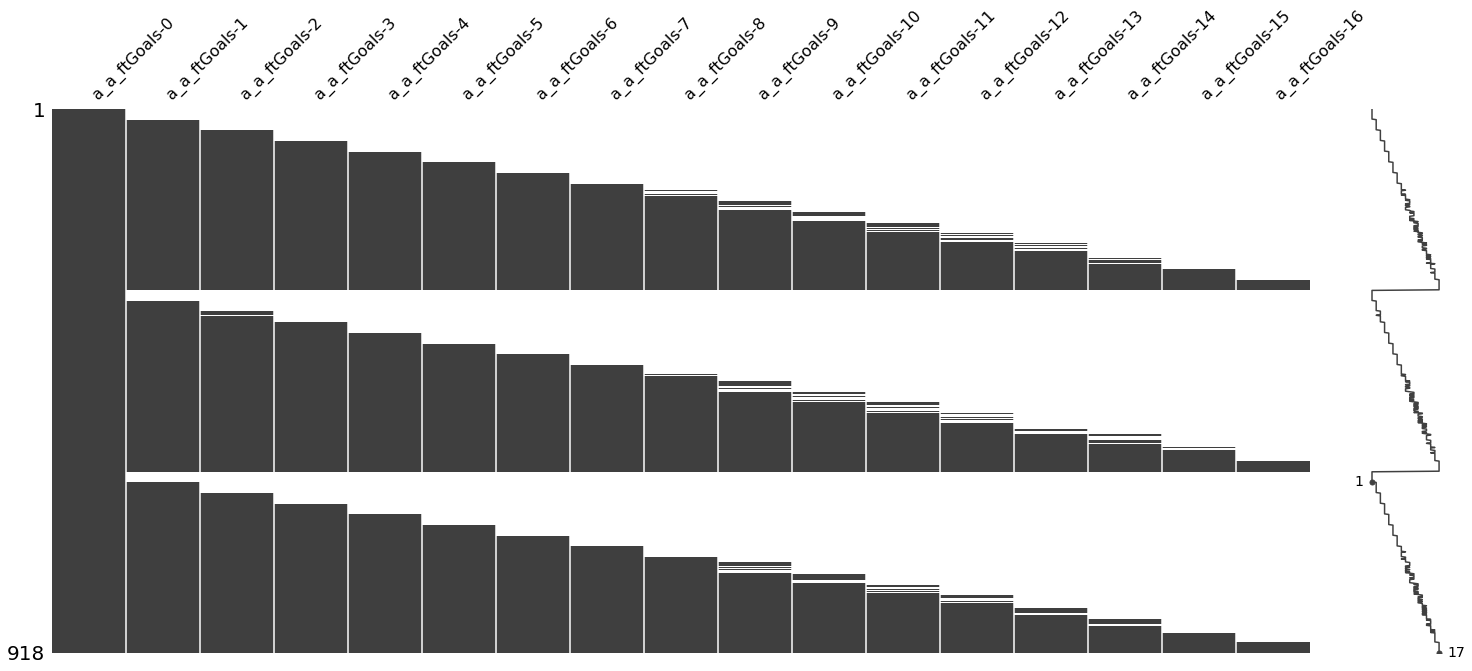

In [24]:
feat_cols = [col for col in df_trans2.columns if 'a_a_ftGoals' in col]
msno.matrix(df_trans2[feat_cols])
plt.show();

In [25]:
drop_cols = [col for col in df_trans2.columns if '-' in col and int(col.rsplit('-')[1]) == 0]
df_trans2.drop(columns=drop_cols, inplace=True)
df_trans2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 417 columns):
nation                  918 non-null object
league                  918 non-null object
season                  918 non-null object
date                    918 non-null datetime64[ns]
h                       918 non-null object
a                       918 non-null object
h_ftGoals               918 non-null float64
a_ftGoals               918 non-null float64
h_shots                 918 non-null float64
a_shots                 918 non-null float64
h_shotsOnTarget         918 non-null float64
a_shotsOnTarget         918 non-null float64
hwinOddsBet365          918 non-null float64
drawOddsBet365          918 non-null float64
awinOddsBet365          918 non-null float64
hwinOddsLb              918 non-null float64
drawOddsLb              918 non-null float64
awinOddsLb              918 non-null float64
awin                    918 non-null int64
draw                    918 non-null in

## 5. Model the Transformed Data

### Pre-Process

##### Cut the Number of Historical Games

There are so many features, it is a bit overwhelming, so we will focus on a few of them for the purposes of illustrating the concepts of the modeling strategy

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [26]:
df_model = df_trans2.copy(deep=True)

def cut_historical_games(df_orig, n_back, drop_all_nan_rows=True, how='all'):
    
    df = df_orig.copy(deep=True)
    feature_cols = [col for col in df.columns if '-' in col]
    non_feature_cols = [col for col in df.columns if col not in feature_cols]
    cut_feature_cols = [col for col in feature_cols if int(col.rsplit('-')[1]) <= n_back]
    return_cols = non_feature_cols + cut_feature_cols
    df = df[return_cols]
    if drop_all_nan_rows:
        df.dropna(subset=cut_feature_cols, axis=0, inplace=True, how=how)
    df.reset_index(drop=True, inplace=True)
    return df
    
n_back=2

df_lastn = cut_historical_games(df_model, n_back=n_back, drop_all_nan_rows=False)
df_lastn.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,a_a_ftGoals-1,a_a_ftGoals-2,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_a_shots-1,a_a_shots-2,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_h_ftGoals-1,a_h_ftGoals-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,a_h_shots-1,a_h_shots-2,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,h_a_ftGoals-1,h_a_ftGoals-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_a_shots-1,h_a_shots-2,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_h_ftGoals-1,h_h_ftGoals-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,h_h_shots-1,h_h_shots-2,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2
0,germany,bundesliga,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,16.0,10.0,7.0,4.0,2.37,3.25,2.87,2.10,3.20,3.0,0,1,0,draw,0,0.003268,0.424403,0.278515,0.297082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,germany,bundesliga,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,27.0,6.0,13.0,0.0,1.16,6.00,19.00,1.20,5.00,11.0,0,0,1,hwin,1,0.022876,0.741240,0.177898,0.080863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,germany,bundesliga,2007-2008,2007-08-11,bochum,sv-werder-bremen,2.0,2.0,17.0,20.0,4.0,9.0,3.50,3.30,2.05,3.20,3.20,2.0,0,1,0,draw,1,0.022876,0.277778,0.277778,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,germany,bundesliga,2007-2008,2007-08-11,eintracht-frankfurt,hertha-berlin,1.0,0.0,19.0,10.0,5.0,3.0,2.37,3.20,2.90,2.37,3.20,2.6,0,0,1,hwin,1,0.022876,0.377051,0.279253,0.343696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,germany,bundesliga,2007-2008,2007-08-11,hannover,hamburger-sv,0.0,1.0,10.0,14.0,2.0,8.0,2.50,3.20,2.75,2.50,3.25,2.4,1,0,0,awin,1,0.022876,0.355758,0.273660,0.370582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_lastn.shape

(918, 75)

In [28]:
df_lastn = cut_historical_games(df_model, n_back=n_back, drop_all_nan_rows=True, how='any')
df_lastn.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,a_a_ftGoals-1,a_a_ftGoals-2,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_a_shots-1,a_a_shots-2,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_h_ftGoals-1,a_h_ftGoals-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,a_h_shots-1,a_h_shots-2,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,h_a_ftGoals-1,h_a_ftGoals-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_a_shots-1,h_a_shots-2,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_h_ftGoals-1,h_h_ftGoals-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,h_h_shots-1,h_h_shots-2,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2
0,germany,bundesliga,2007-2008,2007-09-29,hamburger-sv,wolfsburg,2.0,2.0,20.0,12.0,6.0,2.0,1.66,3.75,5.0,1.50,3.50,6.00,0,1,0,draw,21,0.228758,0.595745,0.255319,0.148936,2.0,1.0,0.231396,0.267672,0.095251,0.237879,0.673352,0.494448,8.0,6.0,3.0,3.0,1.0,1.0,0.210363,0.143831,0.310208,0.074795,0.479415,0.781305,13.0,9.0,5.0,3.0,3.0,1.0,0.269541,0.354313,0.316152,0.224404,0.414307,0.421283,22.0,17.0,9.0,7.0,1.0,1.0,0.098424,0.300258,0.034147,0.699742,0.867220,2.641086e-10,19.0,15.0,5.0,2.0
1,germany,bundesliga,2007-2008,2007-09-29,hansa-rostock,stuttgart,2.0,1.0,11.0,24.0,4.0,8.0,3.60,3.50,2.0,3.20,3.20,2.00,0,0,1,hwin,21,0.228758,0.277778,0.277778,0.444444,1.0,0.0,0.241918,0.178841,0.255831,0.205611,0.502249,0.615461,12.0,17.0,3.0,5.0,1.0,3.0,0.220600,0.296135,0.427398,0.074538,0.351996,0.629328,17.0,24.0,2.0,8.0,3.0,2.0,0.203449,0.151834,0.684202,0.829690,0.112344,0.018467,13.0,9.0,4.0,5.0,2.0,0.0,0.236102,0.130694,0.627703,0.768580,0.136193,1.003556e-01,17.0,25.0,6.0,2.0
2,germany,bundesliga,2007-2008,2007-09-29,karlsruher,dortmund,3.0,1.0,15.0,6.0,6.0,1.0,2.80,3.25,2.5,2.50,3.25,2.40,0,0,1,hwin,21,0.228758,0.355758,0.273660,0.370582,2.0,1.0,0.206531,0.130694,0.633365,0.100356,0.160096,0.768580,23.0,16.0,8.0,4.0,0.0,3.0,0.269541,0.222188,0.414307,0.434241,0.316152,0.343566,7.0,6.0,2.0,5.0,1.0,2.0,0.274299,0.143831,0.568246,0.781305,0.157455,0.074795,14.0,19.0,3.0,6.0,1.0,1.0,0.215220,0.178841,0.708259,0.615461,0.076519,2.056106e-01,15.0,11.0,6.0,5.0
3,germany,bundesliga,2007-2008,2007-09-29,sv-werder-bremen,bielefeld,8.0,1.0,22.0,6.0,12.0,2.0,1.44,4.33,7.0,1.36,4.00,7.00,0,0,1,hwin,21,0.228758,0.651769,0.221601,0.126629,0.0,0.0,0.099622,0.077815,0.808791,0.019070,0.088594,0.902818,2.0,7.0,0.0,2.0,0.0,4.0,0.179318,0.151834,0.274608,0.018467,0.545933,0.829690,12.0,14.0,3.0,7.0,1.0,0.0,0.210363,0.222188,0.479415,0.343566,0.310208,0.434241,16.0,13.0,4.0,4.0,4.0,2.0,0.241918,0.147999,0.502249,0.832505,0.255831,1.948654e-02,21.0,17.0,10.0,7.0
4,germany,bundesliga,2007-2008,2007-09-30,energie-cottbus,eintracht-frankfurt,2.0,2.0,16.0,17.0,7.0,9.0,2.80,3.25,2.5,2.75,3.20,2.25,0,1,0,draw,22,0.235294,0.324507,0.278873,0.396620,0.0,1.0,0.209577,0.147999,0.286235,0.019487,0.504174,0.832505,8.0,11.0,4.0,3.0,0.0,2.0,0.274299,0.354313,0.157455,0.421283,0.568246,0.224404,17.0,16.0,6.0,4.0,0.0,0.0,0.016953,0.296135,0.974928,0.629328,0.001853,0.074538,10.0,7.0,2.0,4.0,1.0,1.0,0.231396,0.551509,0.673352,0.237113,0.095251,2.113786e-01,15.0,18.0,6.0,9.0


In [29]:
df_lastn.shape

(724, 75)

##### Cut the Number of Features

In [30]:
def get_non_feature_cols(df):
    non_feature_cols = [col for col in df.columns if '-' not in col]
    return non_feature_cols

def get_all_feature_cols(df):
    all_feature_cols = [col for col in df.columns if '-' in col]
    return all_feature_cols

#feature_cols = get_all_feature_cols(df_last4)
#my_feature_cols = [col for col in df_lastn.columns if 'poiss' in col or 'shots' in col or 'ftGoals' in col]
#my_feature_cols = [col for col in df_lastn.columns if 'ftGoals' in col]
my_feature_cols = [col for col in df_lastn.columns if 'poiss' in col]
non_feature_cols = get_non_feature_cols(df_lastn)

keeper_cols = non_feature_cols + my_feature_cols
df_lastn_feat = df_lastn[keeper_cols].copy(deep=True)

In [31]:
df_lastn_feat.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2
0,germany,bundesliga,2007-2008,2007-09-29,hamburger-sv,wolfsburg,2.0,2.0,20.0,12.0,6.0,2.0,1.66,3.75,5.0,1.50,3.50,6.00,0,1,0,draw,21,0.228758,0.595745,0.255319,0.148936,0.231396,0.267672,0.095251,0.237879,0.673352,0.494448,0.210363,0.143831,0.310208,0.074795,0.479415,0.781305,0.269541,0.354313,0.316152,0.224404,0.414307,0.421283,0.098424,0.300258,0.034147,0.699742,0.867220,2.641086e-10
1,germany,bundesliga,2007-2008,2007-09-29,hansa-rostock,stuttgart,2.0,1.0,11.0,24.0,4.0,8.0,3.60,3.50,2.0,3.20,3.20,2.00,0,0,1,hwin,21,0.228758,0.277778,0.277778,0.444444,0.241918,0.178841,0.255831,0.205611,0.502249,0.615461,0.220600,0.296135,0.427398,0.074538,0.351996,0.629328,0.203449,0.151834,0.684202,0.829690,0.112344,0.018467,0.236102,0.130694,0.627703,0.768580,0.136193,1.003556e-01
2,germany,bundesliga,2007-2008,2007-09-29,karlsruher,dortmund,3.0,1.0,15.0,6.0,6.0,1.0,2.80,3.25,2.5,2.50,3.25,2.40,0,0,1,hwin,21,0.228758,0.355758,0.273660,0.370582,0.206531,0.130694,0.633365,0.100356,0.160096,0.768580,0.269541,0.222188,0.414307,0.434241,0.316152,0.343566,0.274299,0.143831,0.568246,0.781305,0.157455,0.074795,0.215220,0.178841,0.708259,0.615461,0.076519,2.056106e-01
3,germany,bundesliga,2007-2008,2007-09-29,sv-werder-bremen,bielefeld,8.0,1.0,22.0,6.0,12.0,2.0,1.44,4.33,7.0,1.36,4.00,7.00,0,0,1,hwin,21,0.228758,0.651769,0.221601,0.126629,0.099622,0.077815,0.808791,0.019070,0.088594,0.902818,0.179318,0.151834,0.274608,0.018467,0.545933,0.829690,0.210363,0.222188,0.479415,0.343566,0.310208,0.434241,0.241918,0.147999,0.502249,0.832505,0.255831,1.948654e-02
4,germany,bundesliga,2007-2008,2007-09-30,energie-cottbus,eintracht-frankfurt,2.0,2.0,16.0,17.0,7.0,9.0,2.80,3.25,2.5,2.75,3.20,2.25,0,1,0,draw,22,0.235294,0.324507,0.278873,0.396620,0.209577,0.147999,0.286235,0.019487,0.504174,0.832505,0.274299,0.354313,0.157455,0.421283,0.568246,0.224404,0.016953,0.296135,0.974928,0.629328,0.001853,0.074538,0.231396,0.551509,0.673352,0.237113,0.095251,2.113786e-01


In [32]:
df_lastn_feat.shape

(724, 51)

In [33]:
# Just the feature columns
df_lastn_feat[my_feature_cols].shape

(724, 24)

### Model

In [34]:
df_pre_model = df_lastn_feat.copy(deep=True)

In [35]:
def calc_rps_ss(rps: pd.Series, rps_b: pd.Series):
    """
    Accepts two Series - must be same length
    rps contains rank probability scores for individual events
    rps_b contains benchmark rank probability scores for individual events
    Return the Rank Probability Skill Score for each event as a Series
    """
    RPS_SS = 1 - (rps / rps_b)
    return RPS_SS
    
#df_coded['RPS_SS'] = calc_rps_ss(df_coded['hist_RPS'], df_coded['pinn_RPS'])

#df_coded.head()

In [36]:
def calc_rps(pred_df: pd.DataFrame, obs_df: pd.DataFrame):
    """
    Accepts two DataFrames - DataFrames must be same size
    pred_df contains probability predictions of outcomes in ranked order
    obs_df contains 0 or 1 based on the observed outcome where the 
    outcomes are in the same ranked order
    Return the Rank Probability Score for each row inside a series
    """
    #print(pred_df.values)
    pred_cdf = pred_df.cumsum(axis=1).values
    # print(pred_cdf)
    obs_cdf = obs_df.cumsum(axis=1).values
    # RPS = (pred_cdf - obs_cdf)**2
    #RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS')
    return np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1)
    # print(RPS[0:5])
    #return RPS
    
# RPS = calc_rps(df_test[['p1','p2', 'p3']], df_test[['obs_cat1','obs_cat2', 'obs_cat3']])
# print(f'RPS vector:\n{RPS}\n')
    
# mean_RPS = RPS.mean()
# print(f'Mean RPS: {mean_RPS}\n')

# gmean_RPS = stats.gmean(RPS)
# # print(f'Geometric Mean RPS: {gmean_RPS}\n')

# hmean_RPS = stats.hmean(RPS)
# # print(f'Harmonic Mean RPS: {hmean_RPS}\n')

# sum_RPS = RPS.sum()
# print(f'Sum RPS: {sum_RPS}')

In [37]:
# Test Data form Met Office? Online Course Page - Computation of the Rank Probability Score (RPS) – Accuracy

d = {'p1': [0.7, 0.9, 0.9, 0.8, 0.8, 0.9, 0.6, 0.3, 0.3,0.8, 0.8, 0.0, 0.3],
     'p2': [0.3, 0.1, 0.1, 0.2, 0.2, 0.1, 0.4, 0.4, 0.4, 0.2, 0.2, 0.4, 0.7],
     'p3': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.0, 0.0, 0.6, 0.0],
     'obs_cat': [1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 3 ,2],
     'obs_cat1': [1,1,1,1,1,1,0,0,1,1,0,0,0],
     'obs_cat2': [0,0,0,0,0,0,1,1,0,0,1,0,1],
     'obs_cat3': [0,0,0,0,0,0,0,0,0,0,0,1,0],
     'rps': [0.045, 0.005, 0.005, 0.020, 0.020, 0.005, 0.180, 0.090, 0.29, 0.020, 0.320, 0.080, 0.045]}
df_test = pd.DataFrame(d)
df_test.head(20)

,p1,p2,p3,obs_cat,obs_cat1,obs_cat2,obs_cat3,rps
0,0.7,0.3,0.0,1,1,0,0,0.045
1,0.9,0.1,0.0,1,1,0,0,0.005
2,0.9,0.1,0.0,1,1,0,0,0.005
3,0.8,0.2,0.0,1,1,0,0,0.020
4,0.8,0.2,0.0,1,1,0,0,0.020
5,0.9,0.1,0.0,1,1,0,0,0.005
6,0.6,0.4,0.0,2,0,1,0,0.180
7,0.3,0.4,0.3,2,0,1,0,0.090
8,0.3,0.4,0.3,1,1,0,0,0.290
9,0.8,0.2,0.0,1,1,0,0,0.020


In [38]:
RPS = calc_rps(df_test[['p1','p2', 'p3']], df_test[['obs_cat1','obs_cat2', 'obs_cat3']])
print(f'RPS vector:\n{RPS}\n')

RPS vector:
[0.045 0.005 0.005 0.02  0.02  0.005 0.18  0.09  0.29  0.02  0.32  0.08
 0.045]



In [39]:
df_pre_model.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2
0,germany,bundesliga,2007-2008,2007-09-29,hamburger-sv,wolfsburg,2.0,2.0,20.0,12.0,6.0,2.0,1.66,3.75,5.0,1.50,3.50,6.00,0,1,0,draw,21,0.228758,0.595745,0.255319,0.148936,0.231396,0.267672,0.095251,0.237879,0.673352,0.494448,0.210363,0.143831,0.310208,0.074795,0.479415,0.781305,0.269541,0.354313,0.316152,0.224404,0.414307,0.421283,0.098424,0.300258,0.034147,0.699742,0.867220,2.641086e-10
1,germany,bundesliga,2007-2008,2007-09-29,hansa-rostock,stuttgart,2.0,1.0,11.0,24.0,4.0,8.0,3.60,3.50,2.0,3.20,3.20,2.00,0,0,1,hwin,21,0.228758,0.277778,0.277778,0.444444,0.241918,0.178841,0.255831,0.205611,0.502249,0.615461,0.220600,0.296135,0.427398,0.074538,0.351996,0.629328,0.203449,0.151834,0.684202,0.829690,0.112344,0.018467,0.236102,0.130694,0.627703,0.768580,0.136193,1.003556e-01
2,germany,bundesliga,2007-2008,2007-09-29,karlsruher,dortmund,3.0,1.0,15.0,6.0,6.0,1.0,2.80,3.25,2.5,2.50,3.25,2.40,0,0,1,hwin,21,0.228758,0.355758,0.273660,0.370582,0.206531,0.130694,0.633365,0.100356,0.160096,0.768580,0.269541,0.222188,0.414307,0.434241,0.316152,0.343566,0.274299,0.143831,0.568246,0.781305,0.157455,0.074795,0.215220,0.178841,0.708259,0.615461,0.076519,2.056106e-01
3,germany,bundesliga,2007-2008,2007-09-29,sv-werder-bremen,bielefeld,8.0,1.0,22.0,6.0,12.0,2.0,1.44,4.33,7.0,1.36,4.00,7.00,0,0,1,hwin,21,0.228758,0.651769,0.221601,0.126629,0.099622,0.077815,0.808791,0.019070,0.088594,0.902818,0.179318,0.151834,0.274608,0.018467,0.545933,0.829690,0.210363,0.222188,0.479415,0.343566,0.310208,0.434241,0.241918,0.147999,0.502249,0.832505,0.255831,1.948654e-02
4,germany,bundesliga,2007-2008,2007-09-30,energie-cottbus,eintracht-frankfurt,2.0,2.0,16.0,17.0,7.0,9.0,2.80,3.25,2.5,2.75,3.20,2.25,0,1,0,draw,22,0.235294,0.324507,0.278873,0.396620,0.209577,0.147999,0.286235,0.019487,0.504174,0.832505,0.274299,0.354313,0.157455,0.421283,0.568246,0.224404,0.016953,0.296135,0.974928,0.629328,0.001853,0.074538,0.231396,0.551509,0.673352,0.237113,0.095251,2.113786e-01


In [40]:
df_pre_model.tail()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2
719,germany,bundesliga,2009-2010,2010-05-08,mainz,schalke,0.0,0.0,12.0,10.0,4.0,3.0,2.88,3.40,2.38,2.75,3.25,2.20,0,1,0,draw,91,1.0,0.322981,0.273292,0.403727,0.219055,0.189465,0.139976,0.103878,0.640965,0.706646,0.249390,0.203481,0.314368,0.143764,0.436241,0.652746,0.276826,0.260553,0.502208,0.553279,0.220966,0.186168,0.294628,0.268602,0.350040,0.512748,0.355331,0.218651
720,germany,bundesliga,2009-2010,2010-05-08,nurnberg,fc-koln,1.0,0.0,13.0,5.0,3.0,2.0,1.53,4.33,5.50,1.50,3.60,5.50,0,0,1,hwin,91,1.0,0.591928,0.246637,0.161435,0.218026,0.312553,0.614446,0.428722,0.167523,0.258725,0.295712,0.282909,0.217829,0.258230,0.486460,0.458861,0.207744,0.288391,0.645362,0.347688,0.146886,0.363921,0.234999,0.206520,0.591861,0.559659,0.173138,0.233806
721,germany,bundesliga,2009-2010,2010-05-08,sc-freiburg,dortmund,3.0,1.0,14.0,11.0,3.0,5.0,3.75,3.60,1.91,3.50,3.40,1.83,0,0,1,hwin,91,1.0,0.253680,0.261141,0.485180,0.234999,0.268602,0.173138,0.218651,0.591861,0.512748,0.202721,0.257796,0.260387,0.218201,0.536869,0.524003,0.295712,0.149873,0.486460,0.751040,0.217829,0.098992,0.189947,0.288391,0.610753,0.363921,0.199262,0.347688
722,germany,bundesliga,2009-2010,2010-05-08,sv-werder-bremen,hamburger-sv,1.0,1.0,22.0,15.0,8.0,4.0,1.62,4.00,5.25,1.53,3.75,5.00,0,1,0,draw,91,1.0,0.583431,0.238040,0.178530,0.277257,0.212091,0.275715,0.168380,0.447027,0.619522,0.207744,0.260553,0.146886,0.186168,0.645362,0.553279,0.249390,0.190693,0.436241,0.304434,0.314368,0.504810,0.218026,0.149873,0.167523,0.098992,0.614446,0.751040
723,germany,bundesliga,2009-2010,2010-05-08,wolfsburg,eintracht-frankfurt,3.0,1.0,16.0,19.0,7.0,3.0,1.73,4.00,4.20,1.67,3.60,4.00,0,0,1,hwin,91,1.0,0.531522,0.246567,0.221911,0.294628,0.239704,0.355331,0.314958,0.350040,0.445337,0.261540,0.242531,0.361368,0.214535,0.377091,0.542932,0.202721,0.189947,0.536869,0.199262,0.260387,0.610753,0.190693,0.235173,0.504810,0.369629,0.304434,0.395196


### Prepare the DataFrame for Modeling

We will be using a Rank probability Score to assess our models, therefore we have to ensure we have the right ordinality between home win, draw and away win

In [41]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

ord_enc = OrdinalEncoder(mapping = [{'col': 'result', 'mapping': {'hwin': 1, 'draw': 2, 'awin': 3}}])
df_pre_model['ordinal_result'] = ord_enc.fit_transform(df_pre_model[['result']])#ordinal_encoding(df_pre_model)

one_hot_enc = OneHotEncoder(cols=['ordinal_result'], use_cat_names=True)
one_hot_cols = one_hot_enc.fit_transform(df_pre_model[['ordinal_result']])
new_one_hot_col_names = [col[:-2] for col in one_hot_cols.columns]
mapping_dict = {old: new for old, new in zip(one_hot_cols.columns, new_one_hot_col_names)}
one_hot_cols.rename(columns=mapping_dict, inplace=True)
one_hot_cols = one_hot_cols[sorted(one_hot_cols.columns)]
#one_hot_columns = sorted([col for col in one_hot_cols.columns])
# one_hot_cols = one_hot_cols[sorted(one_hot_cols.columns)]
# one_hot_columns = [col[:-2] for col in one_hot_cols.columns]
# one_hot_cols = one_hot_cols[one_hot_columns]

df_all_cols = pd.concat([df_pre_model, one_hot_cols], axis=1)

df_all_cols.head(13)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3
0,germany,bundesliga,2007-2008,2007-09-29,hamburger-sv,wolfsburg,2.0,2.0,20.0,12.0,6.0,2.0,1.66,3.75,5.00,1.50,3.50,6.00,0,1,0,draw,21,0.228758,0.595745,0.255319,0.148936,0.231396,0.267672,0.095251,0.237879,0.673352,0.494448,0.210363,0.143831,0.310208,0.074795,0.479415,0.781305,0.269541,0.354313,0.316152,0.224404,0.414307,0.421283,0.098424,0.300258,0.034147,0.699742,0.867220,2.641086e-10,2,0,1,0
1,germany,bundesliga,2007-2008,2007-09-29,hansa-rostock,stuttgart,2.0,1.0,11.0,24.0,4.0,8.0,3.60,3.50,2.00,3.20,3.20,2.00,0,0,1,hwin,21,0.228758,0.277778,0.277778,0.444444,0.241918,0.178841,0.255831,0.205611,0.502249,0.615461,0.220600,0.296135,0.427398,0.074538,0.351996,0.629328,0.203449,0.151834,0.684202,0.829690,0.112344,0.018467,0.236102,0.130694,0.627703,0.768580,0.136193,1.003556e-01,1,1,0,0
2,germany,bundesliga,2007-2008,2007-09-29,karlsruher,dortmund,3.0,1.0,15.0,6.0,6.0,1.0,2.80,3.25,2.50,2.50,3.25,2.40,0,0,1,hwin,21,0.228758,0.355758,0.273660,0.370582,0.206531,0.130694,0.633365,0.100356,0.160096,0.768580,0.269541,0.222188,0.414307,0.434241,0.316152,0.343566,0.274299,0.143831,0.568246,0.781305,0.157455,0.074795,0.215220,0.178841,0.708259,0.615461,0.076519,2.056106e-01,1,1,0,0
3,germany,bundesliga,2007-2008,2007-09-29,sv-werder-bremen,bielefeld,8.0,1.0,22.0,6.0,12.0,2.0,1.44,4.33,7.00,1.36,4.00,7.00,0,0,1,hwin,21,0.228758,0.651769,0.221601,0.126629,0.099622,0.077815,0.808791,0.019070,0.088594,0.902818,0.179318,0.151834,0.274608,0.018467,0.545933,0.829690,0.210363,0.222188,0.479415,0.343566,0.310208,0.434241,0.241918,0.147999,0.502249,0.832505,0.255831,1.948654e-02,1,1,0,0
4,germany,bundesliga,2007-2008,2007-09-30,energie-cottbus,eintracht-frankfurt,2.0,2.0,16.0,17.0,7.0,9.0,2.80,3.25,2.50,2.75,3.20,2.25,0,1,0,draw,22,0.235294,0.324507,0.278873,0.396620,0.209577,0.147999,0.286235,0.019487,0.504174,0.832505,0.274299,0.354313,0.157455,0.421283,0.568246,0.224404,0.016953,0.296135,0.974928,0.629328,0.001853,0.074538,0.231396,0.551509,0.673352,0.237113,0.095251,2.113786e-01,2,0,1,0
5,germany,bundesliga,2007-2008,2007-10-05,dortmund,bochum,2.0,1.0,17.0,26.0,5.0,6.0,1.72,3.70,4.75,1.66,3.40,4.33,0,0,1,hwin,23,0.238562,0.534300,0.260864,0.204836,0.220600,0.138022,0.351996,0.764878,0.427398,0.096902,0.236705,0.209577,0.195665,0.504174,0.567628,0.286235,0.186414,0.206531,0.624013,0.633365,0.189529,0.160096,0.269541,0.222188,0.414307,0.434241,0.316152,3.435657e-01,1,1,0,0
6,germany,bundesliga,2007-2008,2007-10-06,bielefeld,hamburger-sv,0.0,1.0,12.0,13.0,3.0,3.0,3.20,3.25,2.25,2.80,3.20,2.20,1,0,0,awin,24,0.258170,0.317690,0.277978,0.404332,0.269541,0.354313,0.316152,0.224404,0.414307,0.421283,0.150367,0.098424,0.062767,0.034147,0.786833,0.867220,0.190975,0.099622,0.564088,0.808791,0.244888,0.088594,0.179318,0.151834,0.274608,0.018467,0.545933,8.296903e-01,3,0,0,1
7,germany,bundesliga,2007-2008,2007-10-06,duisburg,sv-werder-bremen,1.0,3.0,9.0,19.0,4.0,5.0,5.50,3.80,1.61,4.33,3.40,1.66,1,0,0,awin,24,0.258170,0.204836,0.260864,0.534300,0.210363,0.222188,0.479415,0.343566,0.310208,0.434241,0.190975,0.241918,0.244888,0.502249,0.564088,0.255831,0.204857,0.236102,0.663332,0.136193,0.131803,0.627703,0.221611,0.282694,0.629947,0.203460,0.148439,5.138455e-01,3,0,0,1
8,germany,bundesliga,2007-2008,2007-10-06,hertha-berlin,energie-cottbus,0.0,0.0,10.0,15.0,5.0

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [42]:
df = df_all_cols.copy(deep=True)
all_features = get_all_feature_cols(df)
X = df[all_features].copy(deep=True)
X.head(2)

,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2
0,0.231396,0.267672,0.095251,0.237879,0.673352,0.494448,0.210363,0.143831,0.310208,0.074795,0.479415,0.781305,0.269541,0.354313,0.316152,0.224404,0.414307,0.421283,0.098424,0.300258,0.034147,0.699742,0.867220,2.641086e-10
1,0.241918,0.178841,0.255831,0.205611,0.502249,0.615461,0.220600,0.296135,0.427398,0.074538,0.351996,0.629328,0.203449,0.151834,0.684202,0.829690,0.112344,0.018467,0.236102,0.130694,0.627703,0.768580,0.136193,1.003556e-01


In [43]:
non_feature_cols = get_non_feature_cols(df)
meta = df[non_feature_cols].copy(deep=True)
meta.head(2)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3
0,germany,bundesliga,2007-2008,2007-09-29,hamburger-sv,wolfsburg,2.0,2.0,20.0,12.0,6.0,2.0,1.66,3.75,5.0,1.5,3.5,6.0,0,1,0,draw,21,0.228758,0.595745,0.255319,0.148936,2,0,1,0
1,germany,bundesliga,2007-2008,2007-09-29,hansa-rostock,stuttgart,2.0,1.0,11.0,24.0,4.0,8.0,3.60,3.50,2.0,3.2,3.2,2.0,0,0,1,hwin,21,0.228758,0.277778,0.277778,0.444444,1,1,0,0


In [44]:
#y = df[['ordinal_result_1', 'ordinal_result_2', 'ordinal_result_3']].copy(deep=True)
y = df['ordinal_result']
y.head(2)

0    2
1    1
Name: ordinal_result, dtype: int64

In [45]:
# from keras.utils import to_categorical
# yc = to_categorical(y.values)
# yc


In [46]:
# yc.shape

### Model

In [47]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [48]:
# Split into Train, test, but we will also split the additional data for meta data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
meta_train = meta.loc[y_train.index, :]
meta_test = meta.loc[y_test.index, :]
# print(f'train index:{X_train.index}')
# print(f'meta_train index:{meta_train.index}\n')
# print(f'test index: {y_test.index}')
# print(f'meta test index: {meta_test.index}')
X = X_train.copy(deep=True)
y = y_train.copy(deep=True)

In [49]:
X.head(2)

,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2
493,0.126654,0.220068,0.838095,0.611616,0.035207,0.168311,0.070851,0.249017,0.898704,0.225829,0.029288,0.525153,0.188512,0.141987,0.769941,0.809697,0.041543,0.048283,0.270170,0.202089,0.316967,0.674775,0.412863,0.123128
690,0.305932,0.275471,0.278316,0.234975,0.415752,0.489554,0.268602,0.239227,0.512748,0.396953,0.218651,0.363819,0.212091,0.195686,0.168380,0.179953,0.619522,0.624339,0.160251,0.284256,0.108109,0.396104,0.731578,0.319639


In [50]:
y.head(2)

493    1
690    3
Name: ordinal_result, dtype: int64

In [51]:
meta_train.head(2)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3
493,germany,bundesliga,2009-2010,2009-10-17,nurnberg,hertha-berlin,3.0,0.0,18.0,9.0,8.0,3.0,2.15,3.4,3.25,2.1,3.3,2.88,0,0,1,hwin,22,0.258170,0.422738,0.269015,0.308247,1,1,0,0
690,germany,bundesliga,2009-2010,2010-04-17,hamburger-sv,mainz,0.0,1.0,17.0,8.0,5.0,2.0,1.44,4.2,7.50,1.4,4.0,6.50,1,0,0,awin,85,0.905229,0.638821,0.223587,0.137592,3,0,0,1


In [52]:
# https://stackoverflow.com/questions/48508036/
# sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul/51795404#51795404
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)
#clf = MultinomialNB(class_prior=[0.45, 0.25, 0.30])
#clf = CategoricalNB(class_prior=[0.45, 0.25, 0.30])
clf = RandomForestClassifier(max_depth=15, class_weight='balanced', random_state=42)


X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
meta_train = meta_train.reset_index(drop=True)

joined_validate_dfs = []
n = 0
for fit_indices, validate_indices in skf.split(X, y):

    X_fit = X.iloc[fit_indices]
    y_fit = y.iloc[fit_indices]
    
    X_validate = X.iloc[validate_indices]
    y_validate = y.iloc[validate_indices]
    
    meta_fit = meta.iloc[fit_indices]
    meta_validate = meta.iloc[validate_indices]
    
    clf.fit(X_fit, y_fit)
    validate_preds = clf.predict_proba(X_validate)
    
    validate_preds_df = pd.DataFrame(validate_preds, columns = clf.classes_, index=validate_indices)
    
    df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
    df_validate['model_rps'] = calc_rps(validate_preds_df,
                                        meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    df_validate['bookie_rps'] = calc_rps(meta_validate[['implied_hwin', 'implied_draw', 'implied_awin']],
                                         meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    df_validate['rpss'] = calc_rps_ss(df_validate['model_rps'], df_validate['bookie_rps'])
                                  #meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    df_validate['n_fold'] = n
    n += 1
    
    joined_validate_dfs.append(df_validate)




validation_df = pd.concat(joined_validate_dfs, sort=False, axis=0)


In [53]:
joblib.dump(clf, SAMP_MODEL_FP) 

['/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample/models/optimized-model.joblib']

In [54]:
validation_df.head(5)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,1,2,3,model_rps,bookie_rps,rpss,n_fold
2,germany,bundesliga,2007-2008,2007-09-29,karlsruher,dortmund,3.0,1.0,15.0,6.0,6.0,1.0,2.80,3.25,2.50,2.50,3.25,2.40,0,0,1,hwin,21,0.228758,0.355758,0.273660,0.370582,1,1,0,0,0.183734,0.204209,0.651943,0.473277,0.164284,0.322492,0.194141,0.275425,0.173242,0.431506,0.632595,0.293068,0.276107,0.238917,0.161648,0.112206,0.562245,0.648876,0.138154,0.156590,0.062744,0.069435,0.799036,7.739456e-01,0.580000,0.290000,0.130000,0.096650,0.276189,0.650059,0
8,germany,bundesliga,2007-2008,2007-10-06,hertha-berlin,energie-cottbus,0.0,0.0,10.0,15.0,5.0,3.0,1.40,4.33,8.50,1.40,3.75,7.00,0,1,0,draw,24,0.258170,0.635593,0.237288,0.127119,2,0,1,0,0.234569,0.296030,0.557387,0.382745,0.208041,0.321225,0.343682,0.247147,0.419124,0.418401,0.237194,0.334451,0.199461,0.193393,0.544586,0.613087,0.255925,0.193491,0.247280,0.204209,0.292339,0.322492,0.460380,4.732775e-01,0.527221,0.262671,0.210108,0.161054,0.210069,0.233330,0
12,germany,bundesliga,2007-2008,2007-10-07,bayern-munich,nurnberg,3.0,0.0,23.0,12.0,13.0,6.0,1.18,6.50,16.00,1.16,5.50,12.00,0,0,1,hwin,25,0.264706,0.764774,0.161298,0.073928,1,1,0,0,0.106546,0.116387,0.846218,0.826589,0.046993,0.056825,0.369978,0.190734,0.305431,0.647803,0.324590,0.161439,0.389219,0.291995,0.486276,0.667845,0.124505,0.040160,0.341922,0.392265,0.537338,0.607735,0.120740,1.633360e-10,0.310000,0.330000,0.360000,0.302850,0.030398,-8.962724,0
40,germany,bundesliga,2007-2008,2007-11-04,karlsruher,duisburg,1.0,0.0,11.0,17.0,5.0,3.0,1.80,3.50,4.50,1.73,3.20,4.33,0,0,1,hwin,34,0.352941,0.515421,0.278649,0.205930,1,1,0,0,0.232143,0.144453,0.501539,0.752438,0.266315,0.102957,0.240600,0.215136,0.453861,0.533250,0.305538,0.251605,0.224885,0.218807,0.385447,0.266359,0.389664,0.514827,0.112080,0.160276,0.080656,0.181957,0.806512,6.575113e-01,0.723267,0.146704,0.130029,0.046744,0.138612,0.662768,0
43,germany,bundesliga,2007-2008,2007-11-10,hansa-rostock,energie-cottbus,3.0,2.0,18.0,19.0,9.0,4.0,2.00,3.30,3.75,1.90,3.20,3.50,0,0,1,hwin,36,0.375817,0.468032,0.277894,0.254074,1,1,0,0,0.225289,0.254133,0.585382,0.470029,0.189325,0.275837,0.211627,0.289955,0.166988,0.272419,0.621378,0.437626,0.181970,0.206297,0.668538,0.333528,0.149457,0.460156,0.179649,0.196364,0.127807,0.307741,0.692515,4.958555e-01,0.615464,0.149893,0.234643,0.101463,0.173772,0.416116,0


In [55]:
validation_df.tail(5)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,1,2,3,model_rps,bookie_rps,rpss,n_fold
442,germany,bundesliga,2008-2009,2009-05-09,energie-cottbus,bayern-munich,1.0,3.0,8.0,22.0,5.0,12.0,6.50,4.50,1.44,6.50,3.60,1.44,1,0,0,awin,89,0.905229,0.136622,0.246679,0.616698,3,0,0,1,0.226492,0.220560,0.593226,0.623809,0.180278,0.155627,0.253194,0.220526,0.277393,0.267080,0.469413,0.512388,0.235246,0.199215,0.588332,0.641712,0.176420,0.159058,0.287720,0.237584,0.430307,0.486441,0.281974,0.275973,0.332451,0.239846,0.427703,0.219024,0.082793,-1.645438,4
459,germany,bundesliga,2008-2009,2009-05-16,dortmund,bielefeld,6.0,0.0,18.0,10.0,8.0,2.0,1.44,4.33,7.00,1.40,3.75,7.00,0,0,1,hwin,93,0.970588,0.635593,0.237288,0.127119,1,1,0,0,0.231234,0.316943,0.299191,0.328939,0.469573,0.354118,0.096647,0.064980,0.061478,0.029286,0.840793,0.903759,0.260523,0.200897,0.385758,0.512990,0.353718,0.286086,0.190334,0.189127,0.132481,0.283714,0.677169,0.527092,0.395595,0.214698,0.389707,0.258589,0.074476,-2.472121,4
464,germany,bundesliga,2008-2009,2009-05-16,leverkusen,borussia-monchengladbach,5.0,0.0,17.0,13.0,11.0,4.0,2.00,3.40,3.75,1.83,3.40,3.50,0,0,1,hwin,93,0.970588,0.485180,0.261141,0.253680,1,1,0,0,0.226813,0.159726,0.254430,0.069642,0.518753,0.770608,0.274022,0.249136,0.333623,0.272814,0.392354,0.478049,0.248079,0.240331,0.279344,0.260843,0.472576,0.498825,0.202590,0.285684,0.654333,0.498716,0.143067,0.215600,0.462077,0.209621,0.328302,0.198572,0.164697,-0.205683,4
465,germany,bundesliga,2008-2009,2009-05-16,stuttgart,energie-cottbus,2.0,0.0,24.0,8.0,6.0,3.0,1.25,5.50,12.00,1.25,4.50,10.00,0,0,1,hwin,93,0.970588,0.712871,0.198020,0.089109,1,1,0,0,0.343682,0.275425,0.237194,0.293068,0.419124,0.431506,0.309572,0.212036,0.211412,0.078973,0.479015,0.708988,0.291819,0.284620,0.461154,0.555221,0.247027,0.160159,0.237124,0.267816,0.526445,0.434858,0.236429,0.297326,0.273997,0.308867,0.417136,0.350541,0.045192,-6.756770,4
476,germany,bundesliga,2009-2010,2009-09-26,eintracht-frankfurt,stuttgart,0.0,3.0,10.0,20.0,4.0,10.0,2.90,3.30,2.40,2.50,3.30,2.38,1,0,0,awin,17,0.199346,0.356126,0.269792,0.374082,3,0,0,1,0.205759,0.227799,0.574336,0.565211,0.219890,0.206986,0.216300,0.195603,0.659898,0.704952,0.123798,0.099438,0.190816,0.083445,0.670160,0.889887,0.139006,0.026322,0.211243,0.066535,0.569208,0.917675,0.219539,0.015318,0.330000,0.190000,0.480000,0.189650,0.259300,0.268607,4


In [56]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 2 to 476
Data columns (total 62 columns):
nation              485 non-null object
league              485 non-null object
season              485 non-null object
date                485 non-null datetime64[ns]
h                   485 non-null object
a                   485 non-null object
h_ftGoals           485 non-null float64
a_ftGoals           485 non-null float64
h_shots             485 non-null float64
a_shots             485 non-null float64
h_shotsOnTarget     485 non-null float64
a_shotsOnTarget     485 non-null float64
hwinOddsBet365      485 non-null float64
drawOddsBet365      485 non-null float64
awinOddsBet365      485 non-null float64
hwinOddsLb          485 non-null float64
drawOddsLb          485 non-null float64
awinOddsLb          485 non-null float64
awin                485 non-null int64
draw                485 non-null int64
hwin                485 non-null int64
result              485 non-null objec

In [57]:
output_df = validation_df.copy(deep=True)
output_df.reset_index(drop=True, inplace=True)

## Simulate Gambling in Validation Data

In [58]:
output_df.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,1,2,3,model_rps,bookie_rps,rpss,n_fold
0,germany,bundesliga,2007-2008,2007-09-29,karlsruher,dortmund,3.0,1.0,15.0,6.0,6.0,1.0,2.80,3.25,2.50,2.50,3.25,2.40,0,0,1,hwin,21,0.228758,0.355758,0.273660,0.370582,1,1,0,0,0.183734,0.204209,0.651943,0.473277,0.164284,0.322492,0.194141,0.275425,0.173242,0.431506,0.632595,0.293068,0.276107,0.238917,0.161648,0.112206,0.562245,0.648876,0.138154,0.156590,0.062744,0.069435,0.799036,7.739456e-01,0.580000,0.290000,0.130000,0.096650,0.276189,0.650059,0
1,germany,bundesliga,2007-2008,2007-10-06,hertha-berlin,energie-cottbus,0.0,0.0,10.0,15.0,5.0,3.0,1.40,4.33,8.50,1.40,3.75,7.00,0,1,0,draw,24,0.258170,0.635593,0.237288,0.127119,2,0,1,0,0.234569,0.296030,0.557387,0.382745,0.208041,0.321225,0.343682,0.247147,0.419124,0.418401,0.237194,0.334451,0.199461,0.193393,0.544586,0.613087,0.255925,0.193491,0.247280,0.204209,0.292339,0.322492,0.460380,4.732775e-01,0.527221,0.262671,0.210108,0.161054,0.210069,0.233330,0
2,germany,bundesliga,2007-2008,2007-10-07,bayern-munich,nurnberg,3.0,0.0,23.0,12.0,13.0,6.0,1.18,6.50,16.00,1.16,5.50,12.00,0,0,1,hwin,25,0.264706,0.764774,0.161298,0.073928,1,1,0,0,0.106546,0.116387,0.846218,0.826589,0.046993,0.056825,0.369978,0.190734,0.305431,0.647803,0.324590,0.161439,0.389219,0.291995,0.486276,0.667845,0.124505,0.040160,0.341922,0.392265,0.537338,0.607735,0.120740,1.633360e-10,0.310000,0.330000,0.360000,0.302850,0.030398,-8.962724,0
3,germany,bundesliga,2007-2008,2007-11-04,karlsruher,duisburg,1.0,0.0,11.0,17.0,5.0,3.0,1.80,3.50,4.50,1.73,3.20,4.33,0,0,1,hwin,34,0.352941,0.515421,0.278649,0.205930,1,1,0,0,0.232143,0.144453,0.501539,0.752438,0.266315,0.102957,0.240600,0.215136,0.453861,0.533250,0.305538,0.251605,0.224885,0.218807,0.385447,0.266359,0.389664,0.514827,0.112080,0.160276,0.080656,0.181957,0.806512,6.575113e-01,0.723267,0.146704,0.130029,0.046744,0.138612,0.662768,0
4,germany,bundesliga,2007-2008,2007-11-10,hansa-rostock,energie-cottbus,3.0,2.0,18.0,19.0,9.0,4.0,2.00,3.30,3.75,1.90,3.20,3.50,0,0,1,hwin,36,0.375817,0.468032,0.277894,0.254074,1,1,0,0,0.225289,0.254133,0.585382,0.470029,0.189325,0.275837,0.211627,0.289955,0.166988,0.272419,0.621378,0.437626,0.181970,0.206297,0.668538,0.333528,0.149457,0.460156,0.179649,0.196364,0.127807,0.307741,0.692515,4.958555e-01,0.615464,0.149893,0.234643,0.101463,0.173772,0.416116,0


In [59]:
### Identify Poistive EV Bets

In [60]:
output_df['hwin_unit_EV'] = (output_df[1]* (output_df['hwinOddsBet365']-1)) + ((1- output_df[1]) * -1)
output_df['draw_unit_EV'] = (output_df[2]* (output_df['drawOddsBet365']-1)) + ((1- output_df[2]) * -1)
output_df['awin_unit_EV'] = (output_df[3]* (output_df['awinOddsBet365']-1)) + ((1- output_df[3]) * -1)
output_df.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,1,2,3,model_rps,bookie_rps,rpss,n_fold,hwin_unit_EV,draw_unit_EV,awin_unit_EV
0,germany,bundesliga,2007-2008,2007-09-29,karlsruher,dortmund,3.0,1.0,15.0,6.0,6.0,1.0,2.80,3.25,2.50,2.50,3.25,2.40,0,0,1,hwin,21,0.228758,0.355758,0.273660,0.370582,1,1,0,0,0.183734,0.204209,0.651943,0.473277,0.164284,0.322492,0.194141,0.275425,0.173242,0.431506,0.632595,0.293068,0.276107,0.238917,0.161648,0.112206,0.562245,0.648876,0.138154,0.156590,0.062744,0.069435,0.799036,7.739456e-01,0.580000,0.290000,0.130000,0.096650,0.276189,0.650059,0,0.624000,-0.057500,-0.675000
1,germany,bundesliga,2007-2008,2007-10-06,hertha-berlin,energie-cottbus,0.0,0.0,10.0,15.0,5.0,3.0,1.40,4.33,8.50,1.40,3.75,7.00,0,1,0,draw,24,0.258170,0.635593,0.237288,0.127119,2,0,1,0,0.234569,0.296030,0.557387,0.382745,0.208041,0.321225,0.343682,0.247147,0.419124,0.418401,0.237194,0.334451,0.199461,0.193393,0.544586,0.613087,0.255925,0.193491,0.247280,0.204209,0.292339,0.322492,0.460380,4.732775e-01,0.527221,0.262671,0.210108,0.161054,0.210069,0.233330,0,-0.261891,0.137367,0.785915
2,germany,bundesliga,2007-2008,2007-10-07,bayern-munich,nurnberg,3.0,0.0,23.0,12.0,13.0,6.0,1.18,6.50,16.00,1.16,5.50,12.00,0,0,1,hwin,25,0.264706,0.764774,0.161298,0.073928,1,1,0,0,0.106546,0.116387,0.846218,0.826589,0.046993,0.056825,0.369978,0.190734,0.305431,0.647803,0.324590,0.161439,0.389219,0.291995,0.486276,0.667845,0.124505,0.040160,0.341922,0.392265,0.537338,0.607735,0.120740,1.633360e-10,0.310000,0.330000,0.360000,0.302850,0.030398,-8.962724,0,-0.634200,1.145000,4.760000
3,germany,bundesliga,2007-2008,2007-11-04,karlsruher,duisburg,1.0,0.0,11.0,17.0,5.0,3.0,1.80,3.50,4.50,1.73,3.20,4.33,0,0,1,hwin,34,0.352941,0.515421,0.278649,0.205930,1,1,0,0,0.232143,0.144453,0.501539,0.752438,0.266315,0.102957,0.240600,0.215136,0.453861,0.533250,0.305538,0.251605,0.224885,0.218807,0.385447,0.266359,0.389664,0.514827,0.112080,0.160276,0.080656,0.181957,0.806512,6.575113e-01,0.723267,0.146704,0.130029,0.046744,0.138612,0.662768,0,0.301880,-0.486537,-0.414867
4,germany,bundesliga,2007-2008,2007-11-10,hansa-rostock,energie-cottbus,3.0,2.0,18.0,19.0,9.0,4.0,2.00,3.30,3.75,1.90,3.20,3.50,0,0,1,hwin,36,0.375817,0.468032,0.277894,0.254074,1,1,0,0,0.225289,0.254133,0.585382,0.470029,0.189325,0.275837,0.211627,0.289955,0.166988,0.272419,0.621378,0.437626,0.181970,0.206297,0.668538,0.333528,0.149457,0.460156,0.179649,0.196364,0.127807,0.307741,0.692515,4.958555e-01,0.615464,0.149893,0.234643,0.101463,0.173772,0.416116,0,0.230927,-0.505352,-0.120089


In [61]:
threshold = 0.0
output_df[['hwin_bet', 'draw_bet', 'awin_bet']] = \
            output_df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= threshold
output_df.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,1,2,3,model_rps,bookie_rps,rpss,n_fold,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet
0,germany,bundesliga,2007-2008,2007-09-29,karlsruher,dortmund,3.0,1.0,15.0,6.0,6.0,1.0,2.80,3.25,2.50,2.50,3.25,2.40,0,0,1,hwin,21,0.228758,0.355758,0.273660,0.370582,1,1,0,0,0.183734,0.204209,0.651943,0.473277,0.164284,0.322492,0.194141,0.275425,0.173242,0.431506,0.632595,0.293068,0.276107,0.238917,0.161648,0.112206,0.562245,0.648876,0.138154,0.156590,0.062744,0.069435,0.799036,7.739456e-01,0.580000,0.290000,0.130000,0.096650,0.276189,0.650059,0,0.624000,-0.057500,-0.675000,True,False,False
1,germany,bundesliga,2007-2008,2007-10-06,hertha-berlin,energie-cottbus,0.0,0.0,10.0,15.0,5.0,3.0,1.40,4.33,8.50,1.40,3.75,7.00,0,1,0,draw,24,0.258170,0.635593,0.237288,0.127119,2,0,1,0,0.234569,0.296030,0.557387,0.382745,0.208041,0.321225,0.343682,0.247147,0.419124,0.418401,0.237194,0.334451,0.199461,0.193393,0.544586,0.613087,0.255925,0.193491,0.247280,0.204209,0.292339,0.322492,0.460380,4.732775e-01,0.527221,0.262671,0.210108,0.161054,0.210069,0.233330,0,-0.261891,0.137367,0.785915,False,True,True
2,germany,bundesliga,2007-2008,2007-10-07,bayern-munich,nurnberg,3.0,0.0,23.0,12.0,13.0,6.0,1.18,6.50,16.00,1.16,5.50,12.00,0,0,1,hwin,25,0.264706,0.764774,0.161298,0.073928,1,1,0,0,0.106546,0.116387,0.846218,0.826589,0.046993,0.056825,0.369978,0.190734,0.305431,0.647803,0.324590,0.161439,0.389219,0.291995,0.486276,0.667845,0.124505,0.040160,0.341922,0.392265,0.537338,0.607735,0.120740,1.633360e-10,0.310000,0.330000,0.360000,0.302850,0.030398,-8.962724,0,-0.634200,1.145000,4.760000,False,True,True
3,germany,bundesliga,2007-2008,2007-11-04,karlsruher,duisburg,1.0,0.0,11.0,17.0,5.0,3.0,1.80,3.50,4.50,1.73,3.20,4.33,0,0,1,hwin,34,0.352941,0.515421,0.278649,0.205930,1,1,0,0,0.232143,0.144453,0.501539,0.752438,0.266315,0.102957,0.240600,0.215136,0.453861,0.533250,0.305538,0.251605,0.224885,0.218807,0.385447,0.266359,0.389664,0.514827,0.112080,0.160276,0.080656,0.181957,0.806512,6.575113e-01,0.723267,0.146704,0.130029,0.046744,0.138612,0.662768,0,0.301880,-0.486537,-0.414867,True,False,False
4,germany,bundesliga,2007-2008,2007-11-10,hansa-rostock,energie-cottbus,3.0,2.0,18.0,19.0,9.0,4.0,2.00,3.30,3.75,1.90,3.20,3.50,0,0,1,hwin,36,0.375817,0.468032,0.277894,0.254074,1,1,0,0,0.225289,0.254133,0.585382,0.470029,0.189325,0.275837,0.211627,0.289955,0.166988,0.272419,0.621378,0.437626,0.181970,0.206297,0.668538,0.333528,0.149457,0.460156,0.179649,0.196364,0.127807,0.307741,0.692515,4.958555e-01,0.615464,0.149893,0.234643,0.101463,0.173772,0.416116,0,0.230927,-0.505352,-0.120089,True,False,False


In [62]:
conditions = [output_df['ordinal_result_1'] == 1,
              output_df['ordinal_result_1'] == 0]
choices = [(output_df['hwinOddsBet365']-1)* output_df['hwin_bet'], -1* output_df['hwin_bet']]
output_df['hwin_rets'] = np.select(conditions, choices, default=0)

conditions = [output_df['ordinal_result_2'] == 1,
              output_df['ordinal_result_2'] == 0]
choices = [(output_df['drawOddsBet365']-1)* output_df['draw_bet'], -1* output_df['draw_bet']]
output_df['draw_rets'] = np.select(conditions, choices, default=0)

conditions = [output_df['ordinal_result_3'] == 1,
              output_df['ordinal_result_3'] == 0]
choices = [(output_df['awinOddsBet365']-1)* output_df['awin_bet'], -1* output_df['awin_bet']]
output_df['awin_rets'] = np.select(conditions, choices, default=0)
output_df['game_ret'] = output_df[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1)

output_df.head(10)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,1,2,3,model_rps,bookie_rps,rpss,n_fold,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,game_ret
0,germany,bundesliga,2007-2008,2007-09-29,karlsruher,dortmund,3.0,1.0,15.0,6.0,6.0,1.0,2.80,3.25,2.50,2.50,3.25,2.40,0,0,1,hwin,21,0.228758,0.355758,0.273660,0.370582,1,1,0,0,0.183734,0.204209,0.651943,0.473277,0.164284,0.322492,0.194141,0.275425,0.173242,0.431506,0.632595,0.293068,0.276107,0.238917,0.161648,0.112206,0.562245,0.648876,0.138154,0.156590,0.062744,0.069435,0.799036,7.739456e-01,0.580000,0.290000,0.130000,0.096650,0.276189,0.650059,0,0.624000,-0.057500,-0.675000,True,False,False,1.8,0.00,0.0,1.80
1,germany,bundesliga,2007-2008,2007-10-06,hertha-berlin,energie-cottbus,0.0,0.0,10.0,15.0,5.0,3.0,1.40,4.33,8.50,1.40,3.75,7.00,0,1,0,draw,24,0.258170,0.635593,0.237288,0.127119,2,0,1,0,0.234569,0.296030,0.557387,0.382745,0.208041,0.321225,0.343682,0.247147,0.419124,0.418401,0.237194,0.334451,0.199461,0.193393,0.544586,0.613087,0.255925,0.193491,0.247280,0.204209,0.292339,0.322492,0.460380,4.732775e-01,0.527221,0.262671,0.210108,0.161054,0.210069,0.233330,0,-0.261891,0.137367,0.785915,False,True,True,0.0,3.33,-1.0,2.33
2,germany,bundesliga,2007-2008,2007-10-07,bayern-munich,nurnberg,3.0,0.0,23.0,12.0,13.0,6.0,1.18,6.50,16.00,1.16,5.50,12.00,0,0,1,hwin,25,0.264706,0.764774,0.161298,0.073928,1,1,0,0,0.106546,0.116387,0.846218,0.826589,0.046993,0.056825,0.369978,0.190734,0.305431,0.647803,0.324590,0.161439,0.389219,0.291995,0.486276,0.667845,0.124505,0.040160,0.341922,0.392265,0.537338,0.607735,0.120740,1.633360e-10,0.310000,0.330000,0.360000,0.302850,0.030398,-8.962724,0,-0.634200,1.145000,4.760000,False,True,True,0.0,-1.00,-1.0,-2.00
3,germany,bundesliga,2007-2008,2007-11-04,karlsruher,duisburg,1.0,0.0,11.0,17.0,5.0,3.0,1.80,3.50,4.50,1.73,3.20,4.33,0,0,1,hwin,34,0.352941,0.515421,0.278649,0.205930,1,1,0,0,0.232143,0.144453,0.501539,0.752438,0.266315,0.102957,0.240600,0.215136,0.453861,0.533250,0.305538,0.251605,0.224885,0.218807,0.385447,0.266359,0.389664,0.514827,0.112080,0.160276,0.080656,0.181957,0.806512,6.575113e-01,0.723267,0.146704,0.130029,0.046744,0.138612,0.662768,0,0.301880,-0.486537,-0.414867,True,False,False,0.8,0.00,0.0,0.80
4,germany,bundesliga,2007-2008,2007-11-10,hansa-rostock,energie-cottbus,3.0,2.0,18.0,19.0,9.0,4.0,2.00,3.30,3.75,1.90,3.20,3.50,0,0,1,hwin,36,0.375817,0.468032,0.277894,0.254074,1,1,0,0,0.225289,0.254133,0.585382,0.470029,0.189325,0.275837,0.211627,0.289955,0.166988,0.272419,0.621378,0.437626,0.181970,0.206297,0.668538,0.333528,0.149457,0.460156,0.179649,0.196364,0.127807,0.307741,0.692515,4.958555e-01,0.615464,0.149893,0.234643,0.101463,0.173772,0.416116,0,0.230927,-0.505352,-0.120089,True,False,False,1.0,0.00,0.0,1.00
5,germany,bundesliga,2007-2008,2007-11-10,hertha-berlin,hannover,1.0,0.0,13.0,10.0,4.0,3.0,2.15,3.30,3.40,2.10,3.20,3.00,0,0,1,hwin,36,0.375817,0.424403,0.278515,0.297082,1,1,0,0,0.328795,0.337816,0.378781,0.341127,0.292424,0.321056,0.224707,0.318665,0.598020,0.448321,0.177269,0.233015,0.237647,0.284760,0.511003,0.321534,0.251348,0.393706,0.189922,0.232143,0.618097,0.266315,0.191945,5.015389e-01,0.361510,0.263631,0.374859,0.274094,0.209785,-0.306550,0,-0.222753,-0.130018,0.274520,False,False,True,0.0,0.00,-1.0,-1.00
6,germany,bundesliga,2

In [63]:
output_df['hwin_rets'].sum()

27.820000000000004

In [64]:
output_df['draw_rets'].sum()

-7.34

In [65]:
output_df['awin_rets'].sum()

-26.28

In [66]:
output_df[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1).sum()

-5.800000000000004

In [67]:
output_df['rpss'].sum() / len(output_df)

-0.5203763809525546

## Simulate Gambling in Test Data

#### Load the Optimized Model

In [68]:
clf = joblib.load(SAMP_MODEL_FP)
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [69]:
meta_t = meta_test.copy(deep=True)
X_t = X_test.copy(deep=True)
y_t = y_test.copy(deep=True)

meta_t.reset_index(drop=True, inplace=True)
X_t.reset_index(drop=True, inplace=True)
y_t.reset_index(drop=True, inplace=True)

In [70]:
meta_t.head(2)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3
0,germany,bundesliga,2007-2008,2007-12-08,bayern-munich,duisburg,0.0,0.0,22.0,8.0,4.0,2.0,1.14,7.5,17.00,1.14,5.5,15.00,0,1,0,draw,45,0.464052,0.779258,0.161519,0.059224,2,0,1,0
1,germany,bundesliga,2007-2008,2008-05-06,bochum,schalke,0.0,3.0,7.0,11.0,1.0,4.0,4.00,3.3,1.85,3.25,3.4,1.91,1,0,0,awin,92,0.924837,0.273414,0.261352,0.465234,3,0,0,1


In [71]:
X_t.head(2)

,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2
0,0.152850,0.216048,0.797189,0.669277,0.049940,0.114672,0.258067,0.238871,0.405288,0.424335,0.336644,0.336792,0.105502,0.135677,0.043798,0.037882,0.850478,0.826409,0.055490,0.071325,0.019829,0.014125,0.922795,0.914243
1,0.309572,0.237268,0.479015,0.463015,0.211412,0.299715,0.182787,0.200628,0.141111,0.118810,0.676073,0.680554,0.244629,0.199214,0.308076,0.578758,0.447294,0.222004,0.212206,0.234569,0.155531,0.208041,0.632257,0.557387


In [72]:
y_t.head(2)

0    2
1    3
Name: ordinal_result, dtype: int64

In [73]:
test_preds = clf.predict_proba(X_t)
test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
df_test = pd.concat([meta_t, X_t, test_preds_df], sort=False, axis=1)
df_test['model_rps'] = calc_rps(test_preds_df,
                                meta_t[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
df_test['bookie_rps'] = calc_rps(meta_t[['implied_hwin', 'implied_draw', 'implied_awin']],
                                 meta_t[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
df_test['rpss'] = calc_rps_ss(df_test['model_rps'], df_test['bookie_rps'])

In [74]:
df_test['hwin_unit_EV'] = (df_test[1]* (df_test['hwinOddsBet365']-1)) + ((1- df_test[1]) * -1)
df_test['draw_unit_EV'] = (df_test[2]* (df_test['drawOddsBet365']-1)) + ((1- df_test[2]) * -1)
df_test['awin_unit_EV'] = (df_test[3]* (df_test['awinOddsBet365']-1)) + ((1- df_test[3]) * -1)
df_test.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,1,2,3,model_rps,bookie_rps,rpss,hwin_unit_EV,draw_unit_EV,awin_unit_EV
0,germany,bundesliga,2007-2008,2007-12-08,bayern-munich,duisburg,0.0,0.0,22.0,8.0,4.0,2.0,1.14,7.5,17.00,1.14,5.5,15.00,0,1,0,draw,45,0.464052,0.779258,0.161519,0.059224,2,0,1,0,0.152850,0.216048,0.797189,0.669277,0.049940,0.114672,0.258067,0.238871,0.405288,0.424335,0.336644,0.336792,0.105502,0.135677,0.043798,0.037882,0.850478,0.826409,0.055490,0.071325,0.019829,0.014125,0.922795,0.914243,0.548445,0.360000,0.091555,0.154587,0.305375,0.493779,-0.374773,1.700000,0.556438
1,germany,bundesliga,2007-2008,2008-05-06,bochum,schalke,0.0,3.0,7.0,11.0,1.0,4.0,4.00,3.3,1.85,3.25,3.4,1.91,1,0,0,awin,92,0.924837,0.273414,0.261352,0.465234,3,0,0,1,0.309572,0.237268,0.479015,0.463015,0.211412,0.299715,0.182787,0.200628,0.141111,0.118810,0.676073,0.680554,0.244629,0.199214,0.308076,0.578758,0.447294,0.222004,0.212206,0.234569,0.155531,0.208041,0.632257,0.557387,0.514708,0.148855,0.336437,0.352620,0.180365,-0.955036,1.058833,-0.508779,-0.377592
2,germany,bundesliga,2009-2010,2010-05-08,wolfsburg,eintracht-frankfurt,3.0,1.0,16.0,19.0,7.0,3.0,1.73,4.0,4.20,1.67,3.6,4.00,0,0,1,hwin,91,1.000000,0.531522,0.246567,0.221911,1,1,0,0,0.294628,0.239704,0.355331,0.314958,0.350040,0.445337,0.261540,0.242531,0.361368,0.214535,0.377091,0.542932,0.202721,0.189947,0.536869,0.199262,0.260387,0.610753,0.190693,0.235173,0.504810,0.369629,0.304434,0.395196,0.541150,0.261400,0.197450,0.124765,0.134358,0.071399,-0.063810,0.045599,-0.170710
3,germany,bundesliga,2009-2010,2009-10-25,hertha-berlin,wolfsburg,0.0,0.0,18.0,12.0,6.0,3.0,4.75,3.6,1.73,4.50,3.3,1.67,0,1,0,draw,26,0.294118,0.197697,0.269587,0.532716,2,0,1,0,0.067153,0.217858,0.056427,0.590209,0.862775,0.191926,0.056798,0.293445,0.036274,0.246836,0.897818,0.459719,0.320248,0.126654,0.366921,0.838095,0.312831,0.035207,0.070851,0.249017,0.898704,0.225829,0.029288,0.525153,0.280000,0.330000,0.390000,0.115250,0.161435,0.286092,0.330000,0.188000,-0.325300
4,germany,bundesliga,2009-2010,2009-11-21,wolfsburg,nurnberg,2.0,3.0,18.0,23.0,9.0,9.0,1.40,4.5,8.00,1.36,4.0,7.00,1,0,0,awin,33,0.375817,0.651769,0.221601,0.126629,3,0,0,1,0.190334,0.184455,0.677169,0.735342,0.132481,0.080193,0.185256,0.320248,0.744777,0.312831,0.069960,0.366921,0.163065,0.092085,0.712256,0.069071,0.124604,0.836463,0.200897,0.056798,0.286086,0.036274,0.512990,0.897818,0.650000,0.230000,0.120000,0.598450,0.593790,-0.007849,-0.090000,0.035000,-0.040000


In [75]:
threshold = 0.0
df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = \
            df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= threshold
df_test.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,1,2,3,model_rps,bookie_rps,rpss,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet
0,germany,bundesliga,2007-2008,2007-12-08,bayern-munich,duisburg,0.0,0.0,22.0,8.0,4.0,2.0,1.14,7.5,17.00,1.14,5.5,15.00,0,1,0,draw,45,0.464052,0.779258,0.161519,0.059224,2,0,1,0,0.152850,0.216048,0.797189,0.669277,0.049940,0.114672,0.258067,0.238871,0.405288,0.424335,0.336644,0.336792,0.105502,0.135677,0.043798,0.037882,0.850478,0.826409,0.055490,0.071325,0.019829,0.014125,0.922795,0.914243,0.548445,0.360000,0.091555,0.154587,0.305375,0.493779,-0.374773,1.700000,0.556438,False,True,True
1,germany,bundesliga,2007-2008,2008-05-06,bochum,schalke,0.0,3.0,7.0,11.0,1.0,4.0,4.00,3.3,1.85,3.25,3.4,1.91,1,0,0,awin,92,0.924837,0.273414,0.261352,0.465234,3,0,0,1,0.309572,0.237268,0.479015,0.463015,0.211412,0.299715,0.182787,0.200628,0.141111,0.118810,0.676073,0.680554,0.244629,0.199214,0.308076,0.578758,0.447294,0.222004,0.212206,0.234569,0.155531,0.208041,0.632257,0.557387,0.514708,0.148855,0.336437,0.352620,0.180365,-0.955036,1.058833,-0.508779,-0.377592,True,False,False
2,germany,bundesliga,2009-2010,2010-05-08,wolfsburg,eintracht-frankfurt,3.0,1.0,16.0,19.0,7.0,3.0,1.73,4.0,4.20,1.67,3.6,4.00,0,0,1,hwin,91,1.000000,0.531522,0.246567,0.221911,1,1,0,0,0.294628,0.239704,0.355331,0.314958,0.350040,0.445337,0.261540,0.242531,0.361368,0.214535,0.377091,0.542932,0.202721,0.189947,0.536869,0.199262,0.260387,0.610753,0.190693,0.235173,0.504810,0.369629,0.304434,0.395196,0.541150,0.261400,0.197450,0.124765,0.134358,0.071399,-0.063810,0.045599,-0.170710,False,True,False
3,germany,bundesliga,2009-2010,2009-10-25,hertha-berlin,wolfsburg,0.0,0.0,18.0,12.0,6.0,3.0,4.75,3.6,1.73,4.50,3.3,1.67,0,1,0,draw,26,0.294118,0.197697,0.269587,0.532716,2,0,1,0,0.067153,0.217858,0.056427,0.590209,0.862775,0.191926,0.056798,0.293445,0.036274,0.246836,0.897818,0.459719,0.320248,0.126654,0.366921,0.838095,0.312831,0.035207,0.070851,0.249017,0.898704,0.225829,0.029288,0.525153,0.280000,0.330000,0.390000,0.115250,0.161435,0.286092,0.330000,0.188000,-0.325300,True,True,False
4,germany,bundesliga,2009-2010,2009-11-21,wolfsburg,nurnberg,2.0,3.0,18.0,23.0,9.0,9.0,1.40,4.5,8.00,1.36,4.0,7.00,1,0,0,awin,33,0.375817,0.651769,0.221601,0.126629,3,0,0,1,0.190334,0.184455,0.677169,0.735342,0.132481,0.080193,0.185256,0.320248,0.744777,0.312831,0.069960,0.366921,0.163065,0.092085,0.712256,0.069071,0.124604,0.836463,0.200897,0.056798,0.286086,0.036274,0.512990,0.897818,0.650000,0.230000,0.120000,0.598450,0.593790,-0.007849,-0.090000,0.035000,-0.040000,False,True,False


In [76]:
# made the bet
# Get bet result

# conditions = [df_test['hwin_bet'] == 1,
#               df_test['hwin_bet'] == 0]
# choices = [(df_test['hwinOddsBet365']-1)* df_test['hwin_bet'], -1* df_test['hwin_bet']]
# df_test['hwin_rets'] = np.select(conditions, choices, default=0)

conditions = [df_test['ordinal_result_1'] == 1,
              df_test['ordinal_result_1'] == 0]
choices = [(df_test['hwinOddsBet365']-1)* df_test['hwin_bet'], -1* df_test['hwin_bet']]
df_test['hwin_rets'] = np.select(conditions, choices, default=0)

conditions = [df_test['ordinal_result_2'] == 1,
              df_test['ordinal_result_2'] == 0]
choices = [(df_test['drawOddsBet365']-1)* df_test['draw_bet'], -1* df_test['draw_bet']]
df_test['draw_rets'] = np.select(conditions, choices, default=0)

conditions = [df_test['ordinal_result_3'] == 1,
              df_test['ordinal_result_3'] == 0]
choices = [(df_test['awinOddsBet365']-1)* df_test['awin_bet'], -1* df_test['awin_bet']]
df_test['awin_rets'] = np.select(conditions, choices, default=0)
df_test['game_ret'] = df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1)

df_test.head(10)

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,hwinOddsBet365,drawOddsBet365,awinOddsBet365,hwinOddsLb,drawOddsLb,awinOddsLb,awin,draw,hwin,result,game_day,seasonPercentile,implied_hwin,implied_draw,implied_awin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissLose-1,a_a_poissLose-2,a_a_poissWin-1,a_a_poissWin-2,a_h_poissDraw-1,a_h_poissDraw-2,a_h_poissLose-1,a_h_poissLose-2,a_h_poissWin-1,a_h_poissWin-2,h_a_poissDraw-1,h_a_poissDraw-2,h_a_poissLose-1,h_a_poissLose-2,h_a_poissWin-1,h_a_poissWin-2,h_h_poissDraw-1,h_h_poissDraw-2,h_h_poissLose-1,h_h_poissLose-2,h_h_poissWin-1,h_h_poissWin-2,1,2,3,model_rps,bookie_rps,rpss,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,game_ret
0,germany,bundesliga,2007-2008,2007-12-08,bayern-munich,duisburg,0.0,0.0,22.0,8.0,4.0,2.0,1.14,7.50,17.00,1.14,5.5,15.00,0,1,0,draw,45,0.464052,0.779258,0.161519,0.059224,2,0,1,0,0.152850,0.216048,0.797189,0.669277,0.049940,0.114672,0.258067,0.238871,0.405288,0.424335,0.336644,0.336792,0.105502,0.135677,0.043798,0.037882,0.850478,0.826409,0.055490,0.071325,0.019829,0.014125,0.922795,0.914243,0.548445,0.360000,0.091555,0.154587,0.305375,0.493779,-0.374773,1.700000,0.556438,False,True,True,0.0,6.5,-1.0,5.5
1,germany,bundesliga,2007-2008,2008-05-06,bochum,schalke,0.0,3.0,7.0,11.0,1.0,4.0,4.00,3.30,1.85,3.25,3.4,1.91,1,0,0,awin,92,0.924837,0.273414,0.261352,0.465234,3,0,0,1,0.309572,0.237268,0.479015,0.463015,0.211412,0.299715,0.182787,0.200628,0.141111,0.118810,0.676073,0.680554,0.244629,0.199214,0.308076,0.578758,0.447294,0.222004,0.212206,0.234569,0.155531,0.208041,0.632257,0.557387,0.514708,0.148855,0.336437,0.352620,0.180365,-0.955036,1.058833,-0.508779,-0.377592,True,False,False,-1.0,0.0,0.0,-1.0
2,germany,bundesliga,2009-2010,2010-05-08,wolfsburg,eintracht-frankfurt,3.0,1.0,16.0,19.0,7.0,3.0,1.73,4.00,4.20,1.67,3.6,4.00,0,0,1,hwin,91,1.000000,0.531522,0.246567,0.221911,1,1,0,0,0.294628,0.239704,0.355331,0.314958,0.350040,0.445337,0.261540,0.242531,0.361368,0.214535,0.377091,0.542932,0.202721,0.189947,0.536869,0.199262,0.260387,0.610753,0.190693,0.235173,0.504810,0.369629,0.304434,0.395196,0.541150,0.261400,0.197450,0.124765,0.134358,0.071399,-0.063810,0.045599,-0.170710,False,True,False,0.0,-1.0,0.0,-1.0
3,germany,bundesliga,2009-2010,2009-10-25,hertha-berlin,wolfsburg,0.0,0.0,18.0,12.0,6.0,3.0,4.75,3.60,1.73,4.50,3.3,1.67,0,1,0,draw,26,0.294118,0.197697,0.269587,0.532716,2,0,1,0,0.067153,0.217858,0.056427,0.590209,0.862775,0.191926,0.056798,0.293445,0.036274,0.246836,0.897818,0.459719,0.320248,0.126654,0.366921,0.838095,0.312831,0.035207,0.070851,0.249017,0.898704,0.225829,0.029288,0.525153,0.280000,0.330000,0.390000,0.115250,0.161435,0.286092,0.330000,0.188000,-0.325300,True,True,False,-1.0,2.6,0.0,1.6
4,germany,bundesliga,2009-2010,2009-11-21,wolfsburg,nurnberg,2.0,3.0,18.0,23.0,9.0,9.0,1.40,4.50,8.00,1.36,4.0,7.00,1,0,0,awin,33,0.375817,0.651769,0.221601,0.126629,3,0,0,1,0.190334,0.184455,0.677169,0.735342,0.132481,0.080193,0.185256,0.320248,0.744777,0.312831,0.069960,0.366921,0.163065,0.092085,0.712256,0.069071,0.124604,0.836463,0.200897,0.056798,0.286086,0.036274,0.512990,0.897818,0.650000,0.230000,0.120000,0.598450,0.593790,-0.007849,-0.090000,0.035000,-0.040000,False,True,False,0.0,-1.0,0.0,-1.0
5,germany,bundesliga,2009-2010,2009-12-05,eintracht-frankfurt,mainz,2.0,0.0,13.0,13.0,6.0,3.0,2.20,3.25,3.30,2.10,3.3,2.88,0,0,1,hwin,39,0.434641,0.422738,0.269015,0.308247,1,1,0,0,0.260523,0.200897,0.385758,0.512990,0.353718,0.286086,0.221441,0.190334,0.425700,0.132481,0.352853,0.677169,0.241310,0.184259,0.162859,0.733095,0.595830,0.082637,0.248893,0.215316,0.231625,0.154917,0.519481,0.629762,0.398471,0.239660,0.361869,0.246393,0.214124,-0.150706,-0.123364,-0.221105,0.194168,False,False,True,0.0,0.0,-1.0,-1.0
6,germany,bundesliga,2009-2010,2009-11-07,hoffenheim,wolfsburg,1.0,2.0,20.0,13.0,5.0,6.0,

In [77]:
print(df_test['hwin_rets'].sum())
print(df_test['draw_rets'].sum())
print(df_test['awin_rets'].sum())
print()
print(f"Total profit/loss: {df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1).sum()}")

15.210000000000003
9.379999999999999
10.480000000000004

Total profit/loss: 35.07000000000001


In [78]:
print(f"n_bets: {df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")
print(f"n_games: {len(df_test)}")
print(f"Unit Ret per Game: {df_test['game_ret'].sum()/ len(df_test)}")
print(f"Unit Ret per Bet: {df_test['game_ret'].sum()/ df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")

n_bets: 313
n_games: 239
Unit Ret per Game: 0.1467364016736402
Unit Ret per Bet: 0.11204472843450482


In [79]:
df_test['rpss'].sum() / len(df_test)

-0.24284107144523526